### Import Major Libraries

In [573]:
import json
import requests
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

## Define Gameweek and Periods for FDR calculation

In [574]:
gameweek = 9
next_n_games = 2

#define percentage of time player needs to have played to be counted as active
min_min = ((gameweek-1)*90)/4     #<---- Currently 25% of playtime
print(min_min)

180.0


## Define Budget, Team Formation, and Budget Allocation by Position

In [575]:
#Budget
budget = 100

#Team Formation
DF = 3
MD = 4
ST = 3

#Total players needed per position
DF_max = 5
MD_max = 5
ST_max = 3

#Budget Allocation
GK_coef = 0.095
DF_coef = 0.285
MD_coef = 0.36
ST_coef = 0.26

print(sum([GK_coef, DF_coef, MD_coef, ST_coef]))

1.0


## Scraped list of Schedules

In [576]:
schedules = ['Arsenal NEW (A) BUR (H) LIV (A) TOT (H) WAT (A) AVL (H) MUN (A) BOU (H) SHU (A) CRY (H) WOL (H) LEI (A) SOU (H) NOR (A) BHA (H) WHU (A) MCI (H) EVE (A) BOU (A) CHE (H) MUN (H) CRY (A) SHU (H) CHE (A) BUR (A) NEW (H) EVE (H) MCI (A) WHU (H) BHA (A) SOU (A) NOR (H) WOL (A) LEI (H) TOT (A) LIV (H) AVL (A) WAT (H)',
 'Aston Villa TOT (A) BOU (H) EVE (H) CRY (A) WHU (H) ARS (A) BUR (H) NOR (A) BHA (H) MCI (A) LIV (H) WOL (A) NEW (H) MUN (A) CHE (A) LEI (H) SHU (A) SOU (H) NOR (H) WAT (A) BUR (A) MCI (H) BHA (A) WAT (H) BOU (A) TOT (H) SOU (A) SHU (H) LEI (A) CHE (H) NEW (A) WOL (H) LIV (A) MUN (H) CRY (H) EVE (A) ARS (H) WHU (A)',
 'Bournemouth SHU (H) AVL (A) MCI (H) LEI (A) EVE (H) SOU (A) WHU (H) ARS (A) NOR (H) WAT (A) MUN (H) NEW (A) WOL (H) TOT (A) CRY (A) LIV (H) CHE (A) BUR (H) ARS (H) BHA (A) WHU (A) WAT (H) NOR (A) BHA (H) AVL (H) SHU (A) BUR (A) CHE (H) LIV (A) CRY (H) WOL (A) NEW (H) MUN (A) TOT (H) LEI (H) MCI (A) SOU (H) EVE (A)',
 'Brighton WAT (A) WHU (H) SOU (H) MCI (A) BUR (H) NEW (A) CHE (A) TOT (H) AVL (A) EVE (H) NOR (H) MUN (A) LEI (H) LIV (A) ARS (A) WOL (H) CRY (A) SHU (H) TOT (A) BOU (H) CHE (H) EVE (A) AVL (H) BOU (A) WHU (A) WAT (H) SHU (A) CRY (H) WOL (A) ARS (H) LEI (A) MUN (H) NOR (A) LIV (H) MCI (H) SOU (A) NEW (H) BUR (A)',
 'Burnley SOU (H) ARS (A) WOL (A) LIV (H) BHA (A) NOR (H) AVL (A) EVE (H) LEI (A) CHE (H) SHU (A) WHU (H) WAT (A) CRY (H) MCI (H) TOT (A) NEW (H) BOU (A) EVE (A) MUN (H) AVL (H) CHE (A) LEI (H) MUN (A) ARS (H) SOU (A) BOU (H) NEW (A) TOT (H) MCI (A) WAT (H) CRY (A) SHU (H) WHU (A) LIV (A) WOL (H) NOR (A) BHA (H)',
 'Chelsea MUN (A) LEI (H) NOR (A) SHU (H) WOL (A) LIV (H) BHA (H) SOU (A) NEW (H) BUR (A) WAT (A) CRY (H) MCI (A) WHU (H) AVL (H) EVE (A) BOU (H) TOT (A) SOU (H) ARS (A) BHA (A) BUR (H) NEW (A) ARS (H) LEI (A) MUN (H) TOT (H) BOU (A) EVE (H) AVL (A) MCI (H) WHU (A) WAT (H) CRY (A) SHU (A) NOR (H) LIV (A) WOL (H)',
 'Crystal Palace EVE (H) SHU (A) MUN (A) AVL (H) TOT (A) WOL (H) NOR (H) WHU (A) MCI (H) ARS (A) LEI (H) CHE (A) LIV (H) BUR (A) BOU (H) WAT (A) BHA (H) NEW (A) WHU (H) SOU (A) NOR (A) ARS (H) MCI (A) SOU (H) SHU (H) EVE (A) NEW (H) BHA (A) WAT (H) BOU (A) LIV (A) BUR (H) LEI (A) CHE (H) AVL (A) MUN (H) WOL (A) TOT (H)',
 'Everton CRY (A) WAT (H) AVL (A) WOL (H) BOU (A) SHU (H) MCI (H) BUR (A) WHU (H) BHA (A) TOT (H) SOU (A) NOR (H) LEI (A) LIV (A) CHE (H) MUN (A) ARS (H) BUR (H) NEW (A) MCI (A) BHA (H) WHU (A) NEW (H) WAT (A) CRY (H) ARS (A) MUN (H) CHE (A) LIV (H) NOR (A) LEI (H) TOT (A) SOU (H) WOL (A) AVL (H) SHU (A) BOU (H)',
 'Leicester WOL (H) CHE (A) SHU (A) BOU (H) MUN (A) TOT (H) NEW (H) LIV (A) BUR (H) SOU (A) CRY (A) ARS (H) BHA (A) EVE (H) WAT (H) AVL (A) NOR (H) MCI (A) LIV (H) WHU (A) NEW (A) SOU (H) BUR (A) WHU (H) CHE (H) WOL (A) MCI (H) NOR (A) AVL (H) WAT (A) BHA (H) EVE (A) CRY (H) ARS (A) BOU (A) SHU (H) TOT (A) MUN (H)',
 'Liverpool NOR (H) SOU (A) ARS (H) BUR (A) NEW (H) CHE (A) SHU (A) LEI (H) MUN (A) TOT (H) AVL (A) MCI (H) CRY (A) BHA (H) EVE (H) BOU (A) WAT (H) WHU (A) LEI (A) WOL (H) SHU (H) TOT (A) MUN (H) WOL (A) SOU (H) NOR (A) WHU (H) WAT (A) BOU (H) EVE (A) CRY (H) MCI (A) AVL (H) BHA (A) BUR (H) ARS (A) CHE (H) NEW (A)',
 'Man City WHU (A) TOT (H) BOU (A) BHA (H) NOR (A) WAT (H) EVE (A) WOL (H) CRY (A) AVL (H) SOU (H) LIV (A) CHE (H) NEW (A) BUR (A) MUN (H) ARS (A) LEI (H) WOL (A) SHU (H) EVE (H) AVL (A) CRY (H) SHU (A) TOT (A) WHU (H) LEI (A) ARS (H) MUN (A) BUR (H) CHE (A) LIV (H) SOU (A) NEW (H) BHA (A) BOU (H) WAT (A) NOR (H)',
 'Man Utd CHE (H) WOL (A) CRY (H) SOU (A) LEI (H) WHU (A) ARS (H) NEW (A) LIV (H) NOR (A) BOU (A) BHA (H) SHU (A) AVL (H) TOT (H) MCI (A) EVE (H) WAT (A) NEW (H) BUR (A) ARS (A) NOR (H) LIV (A) BUR (H) WOL (H) CHE (A) WAT (H) EVE (A) MCI (H) TOT (A) SHU (H) BHA (A) BOU (H) AVL (A) SOU (H) CRY (A) WHU (H) LEI (A)',
 'Newcastle ARS (H) NOR (A) TOT (A) WAT (H) LIV (A) BHA (H) LEI (A) MUN (H) CHE (A) WOL (H) WHU (A) BOU (H) AVL (A) MCI (H) SHU (A) SOU (H) BUR (A) CRY (H) MUN (A) EVE (H) LEI (H) WOL (A) CHE (H) EVE (A) NOR (H) ARS (A) CRY (A) BUR (H) SOU (A) SHU (H) AVL (H) BOU (A) WHU (H) MCI (A) WAT (A) TOT (H) BHA (A) LIV (H)',
 'Norwich LIV (A) NEW (H) CHE (H) WHU (A) MCI (H) BUR (A) CRY (A) AVL (H) BOU (A) MUN (H) BHA (A) WAT (H) EVE (A) ARS (H) SOU (A) SHU (H) LEI (A) WOL (H) AVL (A) TOT (H) CRY (H) MUN (A) BOU (H) TOT (A) NEW (A) LIV (H) WOL (A) LEI (H) SHU (A) SOU (H) EVE (H) ARS (A) BHA (H) WAT (A) WHU (H) CHE (A) BUR (H) MCI (A)',
 'Sheffield Utd BOU (A) CRY (H) LEI (H) CHE (A) SOU (H) EVE (A) LIV (H) WAT (A) ARS (H) WHU (A) BUR (H) TOT (A) MUN (H) WOL (A) NEW (H) NOR (A) AVL (H) BHA (A) WAT (H) MCI (A) LIV (A) WHU (H) ARS (A) MCI (H) CRY (A) BOU (H) BHA (H) AVL (A) NOR (H) NEW (A) MUN (A) TOT (H) BUR (A) WOL (H) CHE (H) LEI (A) EVE (H) SOU (A)',
 'Southampton BUR (A) LIV (H) BHA (A) MUN (H) SHU (A) BOU (H) TOT (A) CHE (H) WOL (A) LEI (H) MCI (A) EVE (H) ARS (A) WAT (H) NOR (H) NEW (A) WHU (H) AVL (A) CHE (A) CRY (H) TOT (H) LEI (A) WOL (H) CRY (A) LIV (A) BUR (H) AVL (H) WHU (A) NEW (H) NOR (A) ARS (H) WAT (A) MCI (H) EVE (A) MUN (A) BHA (H) BOU (A) SHU (H)',
 'Spurs AVL (H) MCI (A) NEW (H) ARS (A) CRY (H) LEI (A) SOU (H) BHA (A) WAT (H) LIV (A) EVE (A) SHU (H) WHU (A) BOU (H) MUN (A) BUR (H) WOL (A) CHE (H) BHA (H) NOR (A) SOU (A) LIV (H) WAT (A) NOR (H) MCI (H) AVL (A) CHE (A) WOL (H) BUR (A) MUN (H) WHU (H) SHU (A) EVE (H) BOU (A) ARS (H) NEW (A) LEI (H) CRY (A)',
 'Watford BHA (H) EVE (A) WHU (H) NEW (A) ARS (H) MCI (A) WOL (A) SHU (H) TOT (A) BOU (H) CHE (H) NOR (A) BUR (H) SOU (A) LEI (A) CRY (H) LIV (A) MUN (H) SHU (A) AVL (H) WOL (H) BOU (A) TOT (H) AVL (A) EVE (H) BHA (A) MUN (A) LIV (H) CRY (A) LEI (H) BUR (A) SOU (H) CHE (A) NOR (H) NEW (H) WHU (A) MCI (H) ARS (A)',
 'West Ham MCI (H) BHA (A) WAT (A) NOR (H) AVL (A) MUN (H) BOU (A) CRY (H) EVE (A) SHU (H) NEW (H) BUR (A) TOT (H) CHE (A) WOL (A) ARS (H) SOU (A) LIV (H) CRY (A) LEI (H) BOU (H) SHU (A) EVE (H) LEI (A) BHA (H) MCI (A) LIV (A) SOU (H) ARS (A) WOL (H) TOT (A) CHE (H) NEW (A) BUR (H) NOR (A) WAT (H) MUN (A) AVL (H)',
 'Wolves LEI (A) MUN (H) BUR (H) EVE (A) CHE (H) CRY (A) WAT (H) MCI (A) SOU (H) NEW (A) ARS (A) AVL (H) BOU (A) SHU (H) WHU (H) BHA (A) TOT (H) NOR (A) MCI (H) LIV (A) WAT (A) NEW (H) SOU (A) LIV (H) MUN (A) LEI (H) NOR (H) TOT (A) BHA (H) WHU (A) BOU (H) AVL (A) ARS (H) SHU (A) EVE (H) BUR (A) CRY (H) CHE (A)']

### Import Data

In [577]:


# url = "https://fantasy.premierleague.com/drf/bootstrap-static"
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'

def get_json_data(url):
    response = requests.get(url)
    jobs = response.json()
    return jobs

#filter out players with less than 330
all_players = get_json_data(url)['elements']
all_teams = get_json_data(url)['teams']
positions = get_json_data(url)['element_types']

### Get Team Table

In [578]:
table_url = 'https://www.premierleague.com/tables'

def build_table(table_url):
    team_table = pd.read_html(table_url)
    team_df = pd.DataFrame(team_table[0])
    team_df = team_df[team_df['Unnamed: 12'].isna()]
    team_df = team_df.iloc[:,1:10]
    team_df.Club = team_df.Club.map(lambda x: x[-3:])
    team_df.reset_index()
    team_df.index = np.arange(1, len(team_df) + 1)
    team_df.columns = ['Team', 'Played', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']
    team_df.index.name = 'Position'
    
    return team_df

In [579]:
table_url = 'https://www.premierleague.com/tables'
team_table = pd.read_html(table_url)
team_table[0]

Position  Pos  \
0                             1  Previous Position  1   
1   Liverpool  Recent Result - Saturday 5 October ...   
2                             2  Previous Position  2   
3   Manchester City  Recent Result - Sunday 6 Octo...   
4                             3  Previous Position  4   
5   Arsenal  Recent Result - Sunday 6 October 2019...   
6                             4  Previous Position  3   
7   Leicester City  Recent Result - Saturday 5 Oct...   
8                             5  Previous Position  7   
9   Chelsea  Recent Result - Sunday 6 October 2019...   
10                            6  Previous Position  9   
11  Crystal Palace  Recent Result - Saturday 5 Oct...   
12                           7  Previous Position  11   
13  Burnley  Recent Result - Saturday 5 October 20...   
14                            8  Previous Position  5   
15  West Ham United  Recent Result - Saturday 5 Oc...   
16                            9  Previous Position  6   
17  Tottenham Hotspur  Recent Result - Saturday 5 ...   
18                           10  Previous Position  8   
19  Bournemouth  Recent Result - Sunday 6 October ...   
20                          11  Previous Position  13   
21  Wolverhampton Wanderers  Recent Result - Sunda...   
22                          12  Previous Position  10   
23  Manchester United  Recent Result - Sunday 6 Oc...   
24                          13  Previous Position  12   
25  Sheffield United  Recent Result - Saturday 5 O...   
26                          14  Previous Position  16   
27  Brighton and Hove Albion  Recent Result - Satu...   
28                          15  Previous Position  18   
29  Aston Villa  Recent Result - Saturday 5 Octobe...   
30                          16  Previous Position  19   
31  Newcastle United  Recent Result - Sunday 6 Oct...   
32                          17  Previous Position  14   
33  Southampton  Recent Result - Sunday 6 October ...   
34                          18  Previous Position  15   
35  Everton  Recent Result - Saturday 5 October 20...   
36                          19  Previous Position  17   
37  Norwich City  Recent Result - Saturday 5 Octob...   
38                          20  Previous Position  20   
39  Watford  Recent Result - Saturday 5 October 20...   

                                                 Club  \
0                                        LiverpoolLIV   
1   Liverpool  Recent Result - Saturday 5 October ...   
2                                  Manchester CityMCI   
3   Manchester City  Recent Result - Sunday 6 Octo...   
4                                          ArsenalARS   
5   Arsenal  Recent Result - Sunday 6 October 2019...   
6                                   Leicester CityLEI   
7   Leicester City  Recent Result - Saturday 5 Oct...   
8                                          ChelseaCHE   
9   Chelsea  Recent Result - Sunday 6 October 2019...   
10                                  Crystal PalaceCRY   
11  Crystal Palace  Recent Result - Saturday 5 Oct...   
12                                         BurnleyBUR   
13  Burnley  Recent Result - Saturday 5 October 20...   
14                                 West Ham UnitedWHU   
15  West Ham United  Recent Result - Saturday 5 Oc...   
16                               Tottenham HotspurTOT   
17  Tottenham Hotspur  Recent Result - Saturday 5 ...   
18                                     BournemouthBOU   
19  Bournemouth  Recent Result - Sunday 6 October ...   
20                         Wolverhampton WanderersWOL   
21  Wolverhampton Wanderers  Recent Result - Sunda...   
22                               Manchester UnitedMUN   
23  Manchester United  Recent Result - Sunday 6 Oc...   
24                                Sheffield UnitedSHU   
25  Sheffield United  Recent Result - Saturday 5 O...   
26                        Brighton and Hove AlbionBHA   
27  Brighton and Hove Albion  Recent Result - Satu...   
28                                     Aston Vill

In [580]:
table_df = build_table(table_url)

In [581]:
table_df.head()

Team Played  W  D  L  GF  GA   GD Pts
Position                                      
1         LIV      8  8  0  0  20   6  +14  24
2         MCI      8  5  1  2  27   9  +18  16
3         ARS      8  4  3  1  13  11   +2  15
4         LEI      8  4  2  2  14   7   +7  14
5         CHE      8  4  2  2  18  14   +4  14

### Try dynamic FDR Score

In [582]:
#List of teams
name_list = list(table_df.Team)

#list of points as integers
pts_list = [int(item) for item in table_df.Pts]
top_pts = max(pts_list)

#list of GF as integers
GF_list = [int(item) for item in table_df.GF]
top_GF = max(GF_list)

#list of GA as integers
GA_list = [int(item) for item in table_df.GA]
top_GA = max(GA_list)

In [583]:
top_pts, top_GF, top_GA

(24, 27, 21)

In [584]:
name_list[:5]

['LIV', 'MCI', 'ARS', 'LEI', 'CHE']

In [585]:
from scipy import stats
stats.percentileofscore(GF_list, 20)

95.0

In [586]:
scaled = [pts_list, GF_list, GA_list]

### Write Function to try scaled scores

In [587]:
def scaled_FDR(pts_list, GF_list, GA_list):
    #turn to array so you an use scaler
    arr_pts = np.array(pts_list).reshape(-1, 1)
    arr_GF = np.array(GF_list).reshape(-1, 1)
    arr_GA = np.array(GA_list).reshape(-1, 1)
    
    #instantiate scalers
    minmax = MinMaxScaler()
    robust = RobustScaler()
    
    #apply MinMax
    minmax_pts = minmax.fit_transform(arr_pts)
    minmax_GF = minmax.fit_transform(arr_GF)
    minmax_GA = minmax.fit_transform(arr_GA)
    
    #apply Robust
    robu_pts = robust.fit_transform(arr_pts)
    robu_GF = robust.fit_transform(arr_GF)
    robu_GA = robust.fit_transform(arr_GA)
    
    #add normalzied scores
    sum_minmax = (minmax_pts + minmax_GF + (1 - minmax_GA)).tolist()
    sum_robu = (robu_pts + robu_GF + minmax_GA*(-1)).tolist()
    
    minmax_fin = [item[0] for item in sum_minmax]
    robu_fin = [item[0] for item in sum_robu]
    
    return (minmax_fin, robu_fin)
    

In [588]:
scaled_scores = scaled_FDR(pts_list, GF_list, GA_list)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [589]:
scaled_scores[1]

[3.9642857142857144,
 3.7642857142857142,
 0.7976190476190477,
 1.088095238095238,
 1.3833333333333333,
 -0.12142857142857133,
 0.050000000000000044,
 -0.08333333333333326,
 0.25476190476190474,
 -0.002380952380952428,
 -0.4166666666666666,
 -0.7642857142857142,
 -1.0785714285714285,
 -1.088095238095238,
 -0.4357142857142858,
 -2.026190476190476,
 -1.7547619047619047,
 -2.0023809523809524,
 -1.9404761904761902,
 -3.516666666666666]

In [590]:
maybs = [item*2 for item in scaled_scores[0]]

In [591]:
maybs

[5.391304347826087,
 4.838095238095239,
 3.25879917184265,
 3.7838509316770184,
 3.198343685300207,
 3.1287784679089023,
 3.0658385093167704,
 2.7991718426501038,
 2.831469979296066,
 2.611180124223602,
 2.608695652173913,
 2.739544513457557,
 2.6989648033126294,
 2.38592132505176,
 2.4587991718426503,
 1.6298136645962733,
 1.5287784679089027,
 1.6215320910973086,
 0.8074534161490685,
 0.13333333333333353]

<function matplotlib.pyplot.show(*args, **kw)>

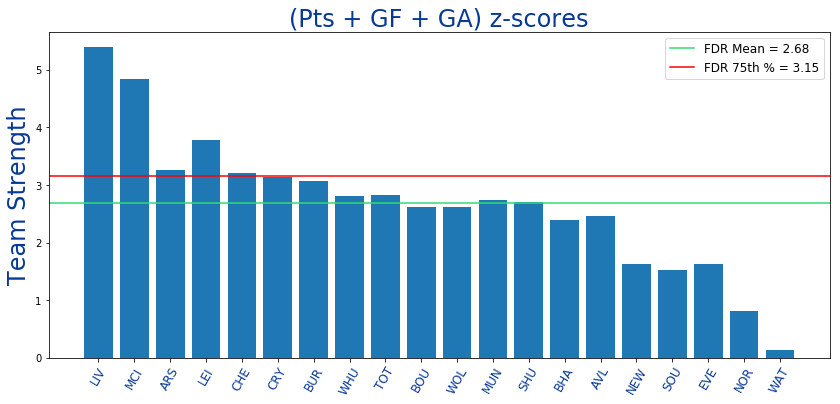

In [777]:
Team = name_list
strength = maybs

mean_FDR = round(np.mean([item for item in maybs]), 2)
FDR_75 = round(np.percentile([item for item in maybs], 75), 2)

plt.bar(Team, strength)
plt.axhline(y=mean_FDR, linestyle='-', color='#33D977', label='FDR Mean = ' + str(mean_FDR))
plt.axhline(y=FDR_75, linestyle='-', color='red', label='FDR 75th % = ' + str(FDR_75))
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('(Pts + GF + GA) z-scores', fontsize = 24, color = '#073997')
plt.legend(fontsize = '12')
plt.show

In [593]:
zipped_list = list(zip(name_list, pts_list, GF_list, GA_list))

In [594]:
zipped_list[:3]

[('LIV', 24, 20, 6), ('MCI', 16, 27, 9), ('ARS', 15, 13, 11)]

In [595]:
def get_percentiles(zipped_list):
    listy = []
    for item in zipped_list:
        team = item[0]
        pts_perc = stats.percentileofscore(pts_list, item[1])
        GF_perc = stats.percentileofscore(GF_list, item[2])
        GA_perc = stats.percentileofscore(GA_list, item[3])
        FDR = pts_perc + GF_perc + (100-GA_perc)
        tup = (team, FDR)
        listy.append(tup)
    return listy
    

In [596]:
FDR_new = get_percentiles(zipped_list)

In [597]:
FDR_new

[('LIV', 290.0),
 ('MCI', 262.5),
 ('ARS', 210.0),
 ('LEI', 250.0),
 ('CHE', 185.0),
 ('CRY', 187.5),
 ('BUR', 190.0),
 ('WHU', 172.5),
 ('TOT', 177.5),
 ('BOU', 152.5),
 ('WOL', 155.0),
 ('MUN', 157.5),
 ('SHU', 147.5),
 ('BHA', 130.0),
 ('AVL', 135.0),
 ('NEW', 62.5),
 ('SOU', 57.5),
 ('EVE', 57.5),
 ('NOR', 55.0),
 ('WAT', 15.0)]

In [598]:
mean_FDR = np.mean([item[1] for item in FDR_new])

In [599]:
mean_FDR

152.5

<function matplotlib.pyplot.show(*args, **kw)>

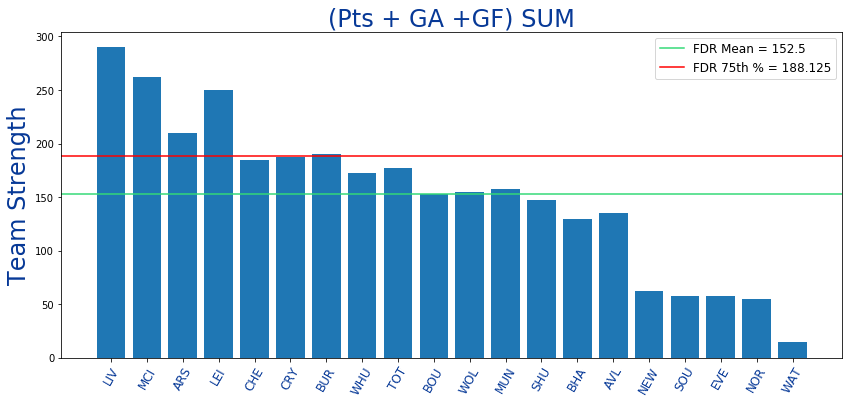

In [778]:
Team = [item[0] for item in FDR_new]
strength = [item[1] for item in FDR_new]

mean_FDR = np.mean([item[1] for item in FDR_new])
FDR_75 = np.percentile([item[1] for item in FDR_new], 75)

plt.bar(Team, strength)
plt.axhline(y=mean_FDR, linestyle='-', color='#33D977', label='FDR Mean = ' + str(mean_FDR))
plt.axhline(y=FDR_75, linestyle='-', color='red', label='FDR 75th % = ' + str(FDR_75))
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('(Pts + GA +GF) SUM', fontsize = 24, color = '#073997')
plt.legend(fontsize = '12')
plt.show

### Function to return percentile for each team

## Add player status and ROI, pts-per-90min metrics to final player_df

In [601]:
def attach_team_and_position(main_players, all_teams, positons):
    players = main_players.copy()
    for team in all_teams:
        for player in players:
            if team['code'] == player['team_code']:
                player['team_name'] = team['name']
    for position in positions:
        for player in players:
            if position['id'] == player['element_type']:
                player['position'] = position['singular_name']
    for player in players:
        if player['status'] == "a":
            player['status'] = "available"
        elif player['status'] == "d":
            player['status'] = "doubtful"
        elif player['status'] == "i":
            player['status'] = "injured"
        elif player['status'] == "s":
            player['status'] = "suspended"
    return players


#### Temporarily took out the "main_players" filter because no players have played 330 minutes ####

# player_positions_teams = attach_team_and_position(main_players, all_teams_new, positions)
player_positions_teams = attach_team_and_position(all_players, all_teams, positions)


def final_players_list(player_positions_teams):
    players = player_positions_teams.copy()
    empty = []
    for player in players:
        stats = dict(team_code = player['team_code'],
        team_name = player['team_name'],
        name = player['first_name'] + " " + player['second_name'],
        status = player['status'],
        position = player['position'],
        cost = (player['now_cost'])/10,
        total_points = player['total_points'],
        roi = round((player['total_points'] / player['now_cost'])*10, 2),
        pts_per_90min = round((player['total_points'] / (player['minutes'] + 1))*90, 2),
        bonus = player['bonus'],
        red_cards = player['red_cards'],
        minutes = player['minutes'],
        transfers_out = player['transfers_out'],
        transfers_in = player['transfers_in'])
        empty.append(stats)
    return empty

In [602]:
final = final_players_list(player_positions_teams)

In [603]:
final[0]

{'team_code': 3,
 'team_name': 'Arsenal',
 'name': 'Shkodran Mustafi',
 'status': 'available',
 'position': 'Defender',
 'cost': 5.3,
 'total_points': 0,
 'roi': 0.0,
 'pts_per_90min': 0.0,
 'bonus': 0,
 'red_cards': 0,
 'minutes': 0,
 'transfers_out': 27079,
 'transfers_in': 5778}

In [604]:
all_teams[0]

{'code': 3,
 'draw': 0,
 'form': None,
 'id': 1,
 'loss': 0,
 'name': 'Arsenal',
 'played': 0,
 'points': 0,
 'position': 0,
 'short_name': 'ARS',
 'strength': 4,
 'team_division': None,
 'unavailable': False,
 'win': 0,
 'strength_overall_home': 1250,
 'strength_overall_away': 1330,
 'strength_attack_home': 1210,
 'strength_attack_away': 1260,
 'strength_defence_home': 1290,
 'strength_defence_away': 1330}

### Get Total ROI, Points and 90min before filtering injured and FDR

In [605]:
total_roi = sorted(final, key = lambda x: x['roi'], reverse = True)

In [606]:
total_roi[:2]

[{'team_code': 49,
  'team_name': 'Sheffield Utd',
  'name': 'John Lundstram',
  'status': 'available',
  'position': 'Defender',
  'cost': 4.5,
  'total_points': 39,
  'roi': 8.67,
  'pts_per_90min': 5.09,
  'bonus': 7,
  'red_cards': 0,
  'minutes': 688,
  'transfers_out': 219785,
  'transfers_in': 1758751},
 {'team_code': 36,
  'team_name': 'Brighton',
  'name': 'Mathew Ryan',
  'status': 'available',
  'position': 'Goalkeeper',
  'cost': 4.6,
  'total_points': 35,
  'roi': 7.61,
  'pts_per_90min': 4.37,
  'bonus': 6,
  'red_cards': 0,
  'minutes': 720,
  'transfers_out': 340431,
  'transfers_in': 441711}]

### Total_Points

In [607]:
total_max_pts = sorted(total_roi, key = lambda x: x['total_points'], reverse = True)

In [608]:
total_max_pts[:2]

[{'team_code': 43,
  'team_name': 'Man City',
  'name': 'Kevin De Bruyne',
  'status': 'doubtful',
  'position': 'Midfielder',
  'cost': 10.0,
  'total_points': 63,
  'roi': 6.3,
  'pts_per_90min': 10.72,
  'bonus': 10,
  'red_cards': 0,
  'minutes': 528,
  'transfers_out': 1298348,
  'transfers_in': 2163800},
 {'team_code': 43,
  'team_name': 'Man City',
  'name': 'Sergio Agüero',
  'status': 'available',
  'position': 'Forward',
  'cost': 12.2,
  'total_points': 61,
  'roi': 5.0,
  'pts_per_90min': 9.79,
  'bonus': 6,
  'red_cards': 0,
  'minutes': 560,
  'transfers_out': 504327,
  'transfers_in': 1178032}]

### 90 min

In [609]:
total_90min = sorted(total_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
total_90min = [player for player in total_90min if player['minutes'] >= min_min]

In [610]:
total_90min[:2]

[{'team_code': 43,
  'team_name': 'Man City',
  'name': 'Kevin De Bruyne',
  'status': 'doubtful',
  'position': 'Midfielder',
  'cost': 10.0,
  'total_points': 63,
  'roi': 6.3,
  'pts_per_90min': 10.72,
  'bonus': 10,
  'red_cards': 0,
  'minutes': 528,
  'transfers_out': 1298348,
  'transfers_in': 2163800},
 {'team_code': 43,
  'team_name': 'Man City',
  'name': 'Sergio Agüero',
  'status': 'available',
  'position': 'Forward',
  'cost': 12.2,
  'total_points': 61,
  'roi': 5.0,
  'pts_per_90min': 9.79,
  'bonus': 6,
  'red_cards': 0,
  'minutes': 560,
  'transfers_out': 504327,
  'transfers_in': 1178032}]

### Create Players DataFrame

In [611]:
player_df = pd.DataFrame(final)

In [612]:
player_df.sort_values(by = ['roi'], ascending = False, inplace = True)

In [613]:
player_df.head(10)

bonus  cost  minutes                           name    position  \
390      7   4.5      688                 John Lundstram    Defender   
96       6   4.6      720                    Mathew Ryan  Goalkeeper   
361      9   7.1      705                    Teemu Pukki     Forward   
538      4   5.1      720  Rui Pedro dos Santos Patrício  Goalkeeper   
403      2   4.5      720                 Dean Henderson  Goalkeeper   
91       7   4.6      720                     Lewis Dunk    Defender   
137      5   4.8      684                   Erik Pieters    Defender   
173      2   4.1      528                   Martin Kelly    Defender   
160     11   7.7      569                  Tammy Abraham     Forward   
171      5   4.6      720                      Joel Ward    Defender   

     pts_per_90min  red_cards   roi     status  team_code       team_name  \
390           5.09          0  8.67  available         49   Sheffield Utd   
96            4.37          0  7.61  available         36        Brighton   
361           6.88          0  7.61  available         45         Norwich   
538           4.74          0  7.45  available         39          Wolves   
403           4.12          0  7.33  available         49   Sheffield Utd   
91            4.12          0  7.17  available         36        Brighton   
137           4.47          0  7.08   doubtful         90         Burnley   
173           4.93          0  7.07  available         31  Crystal Palace   
160           8.53          0  7.01  available          8         Chelsea   
171           3.99          0  6.96  available         31  Crystal Palace   

     total_points  transfers_in  transfers_out  
390            39       1758751         219785  
96             35        441711         340431  
361            54       3169651         963645  
538            38        504045         223477  
403            33        179262          58715  
91             33        526344         314697  
137            34        928240         273759  
173            29        775700         575296  
160            54       2911416         364121  
171            32        251591          73329

### Merge two team tables s owe have all data

In [614]:
def merged_teams(table_df, all_teams):
    table_dic = table_df.to_dict('records')
    
    for team in table_dic:
        for item in all_teams:
            if team['Team'] == item['short_name']:
                team['code'] = item['code']
                team['name'] = item['name']
                team['strength'] = item['strength']
            
    new_df = pd.DataFrame(table_dic)
    
    new_order = ['code', 'strength', 'Team','name', 'Played', 'W', 'L', 'D', 'GF', 'GA', 'GD', 'Pts']
    
    table_df = new_df[new_order]
    
    table_df.index = np.arange(1, len(table_df) + 1)
    table_df.index.name = 'Position'
    
    return table_df
    

In [615]:
team_df = merged_teams(table_df, all_teams)

In [616]:
team_df.head()

code  strength Team       name Played  W  L  D  GF  GA   GD Pts
Position                                                                 
1           14         5  LIV  Liverpool      8  8  0  0  20   6  +14  24
2           43         5  MCI   Man City      8  5  2  1  27   9  +18  16
3            3         4  ARS    Arsenal      8  4  1  3  13  11   +2  15
4           13         3  LEI  Leicester      8  4  2  2  14   7   +7  14
5            8         4  CHE    Chelsea      8  4  2  2  18  14   +4  14

In [617]:
team_names = list(team_df.name)

In [618]:
team_names.sort()

In [619]:
team_names

['Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Leicester',
 'Liverpool',
 'Man City',
 'Man Utd',
 'Newcastle',
 'Norwich',
 'Sheffield Utd',
 'Southampton',
 'Spurs',
 'Watford',
 'West Ham',
 'Wolves']

## Create Schedule DF

In [620]:
def extract_sched(schedules):
    dic = {}
    for i, item in enumerate(schedules):
        name = item.partition(team_names[i])[1]
        sche = item.partition(team_names[i])[2]
        sche = sche.split()
        clean = [item for item in sche if item != "(A)"]
        clean2 = [item for item in clean if item != "(H)"]
        dic[name] = clean2
    return dic

In [621]:
wonders = extract_sched(schedules)

In [622]:
schedule_df = pd.DataFrame(wonders)

In [623]:
schedule_df.index.name = 'Gameweek'

In [624]:
schedule_df.head()

Arsenal Aston Villa Bournemouth Brighton Burnley Chelsea  \
Gameweek                                                            
0            NEW         TOT         SHU      WAT     SOU     MUN   
1            BUR         BOU         AVL      WHU     ARS     LEI   
2            LIV         EVE         MCI      SOU     WOL     NOR   
3            TOT         CRY         LEI      MCI     LIV     SHU   
4            WAT         WHU         EVE      BUR     BHA     WOL   

         Crystal Palace Everton Leicester Liverpool Man City Man Utd  \
Gameweek                                                               
0                   EVE     CRY       WOL       NOR      WHU     CHE   
1                   SHU     WAT       CHE       SOU      TOT     WOL   
2                   MUN     AVL       SHU       ARS      BOU     CRY   
3                   AVL     WOL       BOU       BUR      BHA     SOU   
4                   TOT     BOU       MUN       NEW      NOR     LEI   

         Newcastle Norwich Sheffield Utd Southampton Spurs Watford West Ham  \
Gameweek                                                                      
0              ARS     LIV           BOU         BUR   AVL     BHA      MCI   
1              NOR     NEW           CRY         LIV   MCI     EVE      BHA   
2              TOT     CHE           LEI         BHA   NEW     WHU      WAT   
3              WAT     WHU           CHE         MUN   ARS     NEW      NOR   
4              LIV     MCI           SOU         SHU   CRY     ARS      AVL   

         Wolves  
Gameweek         
0           LEI  
1           MUN  
2           BUR  
3           EVE  
4           CHE

In [625]:
schedule_df.Arsenal[0:3]

Gameweek
0    NEW
1    BUR
2    LIV
Name: Arsenal, dtype: object

## Create FDR scores for calculating next-n opponents AVG strength

In [626]:
scores = list(zip(team_df.Team, team_df.strength))

In [627]:
scores = dict(scores)

In [628]:
sorted(scores.items(), key = lambda x: x[1], reverse = True)

[('LIV', 5),
 ('MCI', 5),
 ('ARS', 4),
 ('CHE', 4),
 ('TOT', 4),
 ('MUN', 4),
 ('LEI', 3),
 ('CRY', 3),
 ('BUR', 3),
 ('WHU', 3),
 ('BOU', 3),
 ('WOL', 3),
 ('NEW', 3),
 ('SOU', 3),
 ('EVE', 3),
 ('NOR', 3),
 ('SHU', 2),
 ('BHA', 2),
 ('AVL', 2),
 ('WAT', 2)]

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

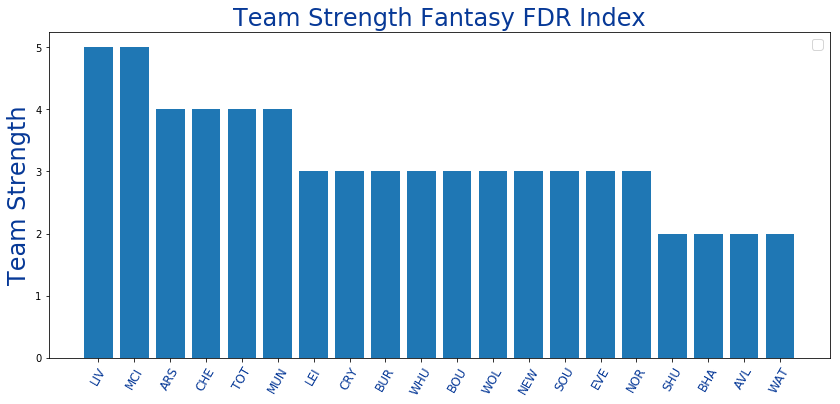

In [629]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# from pylab import rcParams
# rcParams['figure.figsize'] = 14, 6

sorted_data = sorted(scores.items(), key = lambda x: x[1], reverse = True)

Team = [item[0] for item in sorted_data]
strength = [item[1] for item in sorted_data]

plt.bar(Team, strength)
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Team Strength Fantasy FDR Index', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [630]:
maybs

[5.391304347826087,
 4.838095238095239,
 3.25879917184265,
 3.7838509316770184,
 3.198343685300207,
 3.1287784679089023,
 3.0658385093167704,
 2.7991718426501038,
 2.831469979296066,
 2.611180124223602,
 2.608695652173913,
 2.739544513457557,
 2.6989648033126294,
 2.38592132505176,
 2.4587991718426503,
 1.6298136645962733,
 1.5287784679089027,
 1.6215320910973086,
 0.8074534161490685,
 0.13333333333333353]

In [631]:
new_FDR =  list(zip(name_list, maybs))

In [632]:
new_FDR

[('LIV', 5.391304347826087),
 ('MCI', 4.838095238095239),
 ('ARS', 3.25879917184265),
 ('LEI', 3.7838509316770184),
 ('CHE', 3.198343685300207),
 ('CRY', 3.1287784679089023),
 ('BUR', 3.0658385093167704),
 ('WHU', 2.7991718426501038),
 ('TOT', 2.831469979296066),
 ('BOU', 2.611180124223602),
 ('WOL', 2.608695652173913),
 ('MUN', 2.739544513457557),
 ('SHU', 2.6989648033126294),
 ('BHA', 2.38592132505176),
 ('AVL', 2.4587991718426503),
 ('NEW', 1.6298136645962733),
 ('SOU', 1.5287784679089027),
 ('EVE', 1.6215320910973086),
 ('NOR', 0.8074534161490685),
 ('WAT', 0.13333333333333353)]

In [633]:
def get_avg_FDR(sorted_data, new_FDR):
    listy = []
    for item in sorted_data:
        for score in new_FDR:
            if item[0] == score[0]:
                team = item[0]
                avg_FDR = np.round((item[1] + score[1])/2, 2)
                tup = (team, avg_FDR)
                listy.append(tup)
    return listy
    

In [634]:
final_avg_FDR = get_avg_FDR(sorted_data, new_FDR)

In [635]:
final_avg_FDR = sorted(final_avg_FDR, key = lambda x: x[1], reverse = True)
final_avg_FDR

[('LIV', 5.2),
 ('MCI', 4.92),
 ('ARS', 3.63),
 ('CHE', 3.6),
 ('TOT', 3.42),
 ('LEI', 3.39),
 ('MUN', 3.37),
 ('CRY', 3.06),
 ('BUR', 3.03),
 ('WHU', 2.9),
 ('BOU', 2.81),
 ('WOL', 2.8),
 ('SHU', 2.35),
 ('NEW', 2.31),
 ('EVE', 2.31),
 ('SOU', 2.26),
 ('AVL', 2.23),
 ('BHA', 2.19),
 ('NOR', 1.9),
 ('WAT', 1.07)]

In [636]:
adjusted_FDR = dict(final_avg_FDR)

In [637]:
adjusted_FDR

{'LIV': 5.2,
 'MCI': 4.92,
 'ARS': 3.63,
 'CHE': 3.6,
 'TOT': 3.42,
 'LEI': 3.39,
 'MUN': 3.37,
 'CRY': 3.06,
 'BUR': 3.03,
 'WHU': 2.9,
 'BOU': 2.81,
 'WOL': 2.8,
 'SHU': 2.35,
 'NEW': 2.31,
 'EVE': 2.31,
 'SOU': 2.26,
 'AVL': 2.23,
 'BHA': 2.19,
 'NOR': 1.9,
 'WAT': 1.07}

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

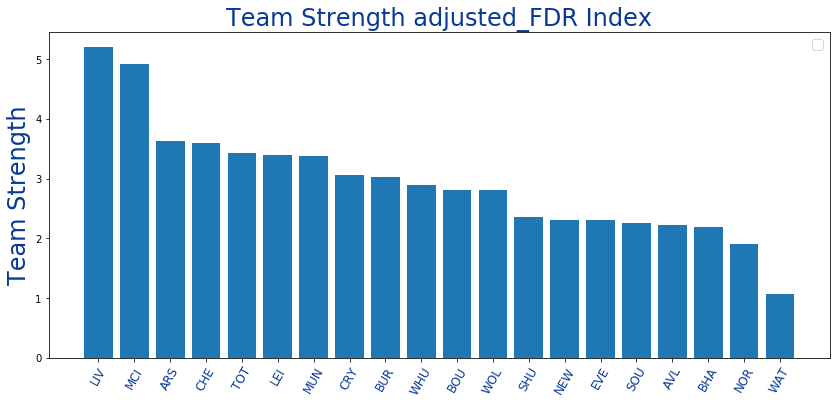

In [638]:
Team = [item[0] for item in final_avg_FDR]
strength = [item[1] for item in final_avg_FDR]

plt.bar(Team, strength)
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Team Strength adjusted_FDR Index', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [639]:
schedule_df.columns

Index(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brighton', 'Burnley',
       'Chelsea', 'Crystal Palace', 'Everton', 'Leicester', 'Liverpool',
       'Man City', 'Man Utd', 'Newcastle', 'Norwich', 'Sheffield Utd',
       'Southampton', 'Spurs', 'Watford', 'West Ham', 'Wolves'],
      dtype='object')

In [640]:
schedule_df.head(10)

Arsenal Aston Villa Bournemouth Brighton Burnley Chelsea  \
Gameweek                                                            
0            NEW         TOT         SHU      WAT     SOU     MUN   
1            BUR         BOU         AVL      WHU     ARS     LEI   
2            LIV         EVE         MCI      SOU     WOL     NOR   
3            TOT         CRY         LEI      MCI     LIV     SHU   
4            WAT         WHU         EVE      BUR     BHA     WOL   
5            AVL         ARS         SOU      NEW     NOR     LIV   
6            MUN         BUR         WHU      CHE     AVL     BHA   
7            BOU         NOR         ARS      TOT     EVE     SOU   
8            SHU         BHA         NOR      AVL     LEI     NEW   
9            CRY         MCI         WAT      EVE     CHE     BUR   

         Crystal Palace Everton Leicester Liverpool Man City Man Utd  \
Gameweek                                                               
0                   EVE     CRY       WOL       NOR      WHU     CHE   
1                   SHU     WAT       CHE       SOU      TOT     WOL   
2                   MUN     AVL       SHU       ARS      BOU     CRY   
3                   AVL     WOL       BOU       BUR      BHA     SOU   
4                   TOT     BOU       MUN       NEW      NOR     LEI   
5                   WOL     SHU       TOT       CHE      WAT     WHU   
6                   NOR     MCI       NEW       SHU      EVE     ARS   
7                   WHU     BUR       LIV       LEI      WOL     NEW   
8                   MCI     WHU       BUR       MUN      CRY     LIV   
9                   ARS     BHA       SOU       TOT      AVL     NOR   

         Newcastle Norwich Sheffield Utd Southampton Spurs Watford West Ham  \
Gameweek                                                                      
0              ARS     LIV           BOU         BUR   AVL     BHA      MCI   
1              NOR     NEW           CRY         LIV   MCI     EVE      BHA   
2              TOT     CHE           LEI         BHA   NEW     WHU      WAT   
3              WAT     WHU           CHE         MUN   ARS     NEW      NOR   
4              LIV     MCI           SOU         SHU   CRY     ARS      AVL   
5              BHA     BUR           EVE         BOU   LEI     MCI      MUN   
6              LEI     CRY           LIV         TOT   SOU     WOL      BOU   
7              MUN     AVL           WAT         CHE   BHA     SHU      CRY   
8              CHE     BOU           ARS         WOL   WAT     TOT      EVE   
9              WOL     MUN           WHU         LEI   LIV     BOU      SHU   

         Wolves  
Gameweek         
0           LEI  
1           MUN  
2           BUR  
3           EVE  
4           CHE  
5           CRY  
6           WAT  
7           MCI  
8           SOU  
9           NEW

In [641]:
def avg_FDR(scores = adjusted_FDR, week = gameweek, periods = next_n_games):
    dic = {}
    for team in schedule_df.columns:
        oponents = schedule_df[team][(week-1):(week+periods)]
        avg_FDR = round(sum([scores[oponent] for oponent in oponents])/len(oponents), 2)
        dic[team] = avg_FDR
    return dic

In [642]:
calculate_FDR = avg_FDR()

In [643]:
sorted_FDR = sorted(calculate_FDR.items(), key=lambda x: x[1], reverse=True)

In [644]:
sorted_FDR

[('Aston Villa', 4.1),
 ('Crystal Palace', 3.98),
 ('Southampton', 3.7),
 ('Man Utd', 3.3),
 ('Watford', 3.28),
 ('Sheffield Utd', 3.19),
 ('Burnley', 3.11),
 ('Newcastle', 3.1),
 ('Liverpool', 3.01),
 ('Spurs', 2.86),
 ('Everton', 2.84),
 ('Norwich', 2.79),
 ('Leicester', 2.78),
 ('Arsenal', 2.74),
 ('Wolves', 2.73),
 ('Man City', 2.52),
 ('West Ham', 2.32),
 ('Brighton', 2.15),
 ('Chelsea', 2.14),
 ('Bournemouth', 2.11)]

<function matplotlib.pyplot.show(*args, **kw)>

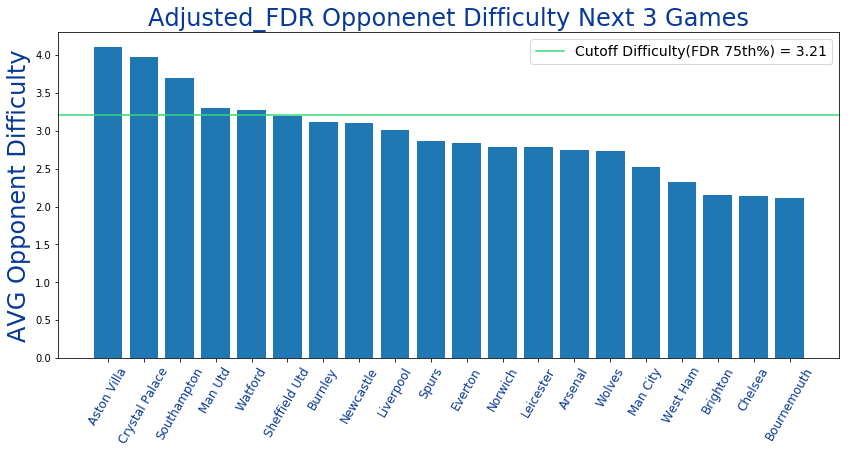

In [645]:
rcParams['figure.figsize'] = 14, 6

Team = [item[0] for item in sorted_FDR]
FDR = [item[1] for item in sorted_FDR]

FDR_75 = round(np.percentile([item[1] for item in sorted_FDR], 75), 2)
cutoff = FDR_75

plt.bar(Team, FDR)
plt.axhline(y=cutoff, linestyle='-', color='#33D977', label='Cutoff Difficulty(FDR 75th%) = ' + str(cutoff))
plt.ylabel('AVG Opponent Difficulty', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Adjusted_FDR Opponenet Difficulty Next ' + str(next_n_games +1) + ' Games', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Clean final list of available players by FDR score <= 3.56 and status = 'available'

In [646]:
player_df.head()

bonus  cost  minutes                           name    position  \
390      7   4.5      688                 John Lundstram    Defender   
96       6   4.6      720                    Mathew Ryan  Goalkeeper   
361      9   7.1      705                    Teemu Pukki     Forward   
538      4   5.1      720  Rui Pedro dos Santos Patrício  Goalkeeper   
403      2   4.5      720                 Dean Henderson  Goalkeeper   

     pts_per_90min  red_cards   roi     status  team_code      team_name  \
390           5.09          0  8.67  available         49  Sheffield Utd   
96            4.37          0  7.61  available         36       Brighton   
361           6.88          0  7.61  available         45        Norwich   
538           4.74          0  7.45  available         39         Wolves   
403           4.12          0  7.33  available         49  Sheffield Utd   

     total_points  transfers_in  transfers_out  
390            39       1758751         219785  
96             35        441711         340431  
361            54       3169651         963645  
538            38        504045         223477  
403            33        179262          58715

In [647]:
player_df.shape

(551, 14)

In [648]:
clean_df = player_df[player_df.status == 'available']

In [649]:
clean_df.status.value_counts()

available    403
Name: status, dtype: int64

## Remove teams with FDR scores > 3.56 from DF - optional

In [650]:
teams_low_FDR = [key for (key,value) in calculate_FDR.items() if value <= cutoff]

In [651]:
teams_low_FDR

['Arsenal',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Chelsea',
 'Everton',
 'Leicester',
 'Liverpool',
 'Man City',
 'Newcastle',
 'Norwich',
 'Sheffield Utd',
 'Spurs',
 'West Ham',
 'Wolves']

In [652]:
clean_df.head()

bonus  cost  minutes                           name    position  \
390      7   4.5      688                 John Lundstram    Defender   
96       6   4.6      720                    Mathew Ryan  Goalkeeper   
361      9   7.1      705                    Teemu Pukki     Forward   
538      4   5.1      720  Rui Pedro dos Santos Patrício  Goalkeeper   
403      2   4.5      720                 Dean Henderson  Goalkeeper   

     pts_per_90min  red_cards   roi     status  team_code      team_name  \
390           5.09          0  8.67  available         49  Sheffield Utd   
96            4.37          0  7.61  available         36       Brighton   
361           6.88          0  7.61  available         45        Norwich   
538           4.74          0  7.45  available         39         Wolves   
403           4.12          0  7.33  available         49  Sheffield Utd   

     total_points  transfers_in  transfers_out  
390            39       1758751         219785  
96             35        441711         340431  
361            54       3169651         963645  
538            38        504045         223477  
403            33        179262          58715

In [653]:
final_df = clean_df.loc[clean_df.team_name.isin(teams_low_FDR)]

In [654]:
final_df.head(15)

bonus  cost  minutes                              name    position  \
390      7   4.5      688                    John Lundstram    Defender   
96       6   4.6      720                       Mathew Ryan  Goalkeeper   
361      9   7.1      705                       Teemu Pukki     Forward   
538      4   5.1      720     Rui Pedro dos Santos Patrício  Goalkeeper   
403      2   4.5      720                    Dean Henderson  Goalkeeper   
91       7   4.6      720                        Lewis Dunk    Defender   
160     11   7.7      569                     Tammy Abraham     Forward   
126      2   4.7      720                         Nick Pope  Goalkeeper   
163      6   6.8      709                       Mason Mount  Midfielder   
387      3   4.5      720                    George Baldock    Defender   
384      4   5.0      720                      Enda Stevens    Defender   
217      5   6.2      720  Ricardo Domingos Barbosa Pereira    Defender   
532      7   5.0      630                        Willy Boly    Defender   
544      6   5.0      470                      Adama Traoré  Midfielder   
348      3   4.5      387                     Jetro Willems    Defender   

     pts_per_90min  red_cards   roi     status  team_code      team_name  \
390           5.09          0  8.67  available         49  Sheffield Utd   
96            4.37          0  7.61  available         36       Brighton   
361           6.88          0  7.61  available         45        Norwich   
538           4.74          0  7.45  available         39         Wolves   
403           4.12          0  7.33  available         49  Sheffield Utd   
91            4.12          0  7.17  available         36       Brighton   
160           8.53          0  7.01  available          8        Chelsea   
126           3.99          0  6.81  available         90        Burnley   
163           5.83          0  6.76  available          8        Chelsea   
387           3.74          0  6.67  available         49  Sheffield Utd   
384           4.12          0  6.60  available         49  Sheffield Utd   
217           4.99          0  6.45  available         13      Leicester   
532           4.56          1  6.40  available         39         Wolves   
544           6.11          0  6.40  available         39         Wolves   
348           6.49          0  6.22  available          4      Newcastle   

     total_points  transfers_in  transfers_out  
390            39       1758751         219785  
96             35        441711         340431  
361            54       3169651         963645  
538            38        504045         223477  
403            33        179262          58715  
91             33        526344         314697  
160            54       2911416         364121  
126            32        762962         201718  
163            46       2725547         580007  
387            30         53208          21533  
384            33         38585          20707  
217            40        457911         179996  
532            32        249203         322008  
544            32         97668          23130  
348            28         28362          13648

In [655]:
clean_players = final_df.to_dict('records')

In [656]:
clean_players[:2]

[{'bonus': 7,
  'cost': 4.5,
  'minutes': 688,
  'name': 'John Lundstram',
  'position': 'Defender',
  'pts_per_90min': 5.09,
  'red_cards': 0,
  'roi': 8.67,
  'status': 'available',
  'team_code': 49,
  'team_name': 'Sheffield Utd',
  'total_points': 39,
  'transfers_in': 1758751,
  'transfers_out': 219785},
 {'bonus': 6,
  'cost': 4.6,
  'minutes': 720,
  'name': 'Mathew Ryan',
  'position': 'Goalkeeper',
  'pts_per_90min': 4.37,
  'red_cards': 0,
  'roi': 7.61,
  'status': 'available',
  'team_code': 36,
  'team_name': 'Brighton',
  'total_points': 35,
  'transfers_in': 441711,
  'transfers_out': 340431}]

## Get list of players by ROI, Total Points and Points Per 90 min

In [657]:
players_roi = sorted(clean_players, key = lambda x: x['roi'], reverse = True)

In [658]:
players_roi[:3]

[{'bonus': 7,
  'cost': 4.5,
  'minutes': 688,
  'name': 'John Lundstram',
  'position': 'Defender',
  'pts_per_90min': 5.09,
  'red_cards': 0,
  'roi': 8.67,
  'status': 'available',
  'team_code': 49,
  'team_name': 'Sheffield Utd',
  'total_points': 39,
  'transfers_in': 1758751,
  'transfers_out': 219785},
 {'bonus': 6,
  'cost': 4.6,
  'minutes': 720,
  'name': 'Mathew Ryan',
  'position': 'Goalkeeper',
  'pts_per_90min': 4.37,
  'red_cards': 0,
  'roi': 7.61,
  'status': 'available',
  'team_code': 36,
  'team_name': 'Brighton',
  'total_points': 35,
  'transfers_in': 441711,
  'transfers_out': 340431},
 {'bonus': 9,
  'cost': 7.1,
  'minutes': 705,
  'name': 'Teemu Pukki',
  'position': 'Forward',
  'pts_per_90min': 6.88,
  'red_cards': 0,
  'roi': 7.61,
  'status': 'available',
  'team_code': 45,
  'team_name': 'Norwich',
  'total_points': 54,
  'transfers_in': 3169651,
  'transfers_out': 963645}]

### Total Points

In [659]:
players_max_pts = sorted(players_roi, key = lambda x: x['total_points'], reverse = True)

In [660]:
players_max_pts[:3]

[{'bonus': 6,
  'cost': 12.2,
  'minutes': 560,
  'name': 'Sergio Agüero',
  'position': 'Forward',
  'pts_per_90min': 9.79,
  'red_cards': 0,
  'roi': 5.0,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 61,
  'transfers_in': 1178032,
  'transfers_out': 504327},
 {'bonus': 8,
  'cost': 11.7,
  'minutes': 606,
  'name': 'Sadio Mané',
  'position': 'Midfielder',
  'pts_per_90min': 8.45,
  'red_cards': 0,
  'roi': 4.87,
  'status': 'available',
  'team_code': 14,
  'team_name': 'Liverpool',
  'total_points': 57,
  'transfers_in': 1332868,
  'transfers_out': 633541},
 {'bonus': 10,
  'cost': 11.1,
  'minutes': 720,
  'name': 'Pierre-Emerick Aubameyang',
  'position': 'Forward',
  'pts_per_90min': 6.87,
  'red_cards': 0,
  'roi': 4.95,
  'status': 'available',
  'team_code': 3,
  'team_name': 'Arsenal',
  'total_points': 55,
  'transfers_in': 926758,
  'transfers_out': 848103}]

### Per 90 mins played

In [661]:
players_90min = sorted(players_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
players_90min = [player for player in players_90min if player['minutes'] >= min_min]

In [662]:
players_90min[:3]

[{'bonus': 6,
  'cost': 12.2,
  'minutes': 560,
  'name': 'Sergio Agüero',
  'position': 'Forward',
  'pts_per_90min': 9.79,
  'red_cards': 0,
  'roi': 5.0,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 61,
  'transfers_in': 1178032,
  'transfers_out': 504327},
 {'bonus': 3,
  'cost': 5.3,
  'minutes': 225,
  'name': 'James Milner',
  'position': 'Midfielder',
  'pts_per_90min': 9.16,
  'red_cards': 0,
  'roi': 4.34,
  'status': 'available',
  'team_code': 14,
  'team_name': 'Liverpool',
  'total_points': 23,
  'transfers_in': 23185,
  'transfers_out': 44074},
 {'bonus': 6,
  'cost': 8.7,
  'minutes': 457,
  'name': 'Riyad Mahrez',
  'position': 'Midfielder',
  'pts_per_90min': 9.04,
  'red_cards': 0,
  'roi': 5.29,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 46,
  'transfers_in': 724013,
  'transfers_out': 286460}]

### Create player lists by position and metric we want to select by

In [663]:
GK_roi = [item for item in players_roi if item['position'] == 'Goalkeeper']
DF_roi = [item for item in players_roi if item['position'] == 'Defender']
MD_roi = [item for item in players_roi if item['position'] == 'Midfielder']
ST_roi = [item for item in players_roi if item['position'] == 'Forward']

In [664]:
GK_pts = [item for item in players_max_pts if item['position'] == 'Goalkeeper']
DF_pts = [item for item in players_max_pts if item['position'] == 'Defender']
MD_pts = [item for item in players_max_pts if item['position'] == 'Midfielder']
ST_pts = [item for item in players_max_pts if item['position'] == 'Forward']

In [665]:
GK_90min = [item for item in players_90min if item['position'] == 'Goalkeeper']
DF_90min = [item for item in players_90min if item['position'] == 'Defender']
MD_90min = [item for item in players_90min if item['position'] == 'Midfielder']
ST_90min = [item for item in players_90min if item['position'] == 'Forward']

## Start by selecting top GKs by ROI

In [666]:
#define money team as empty list and list that tracks count of players selectd per team
money_team = []
players_selected = []
teams_selected = []

#Instantiate initial count per position
#Current players selected for each position
DF_curr = 0
MD_curr = 0 
ST_curr = 0

GK_budget = budget*GK_coef
print(GK_budget)

for item in GK_roi:
    if item['cost'] <= 5.5 and item['cost'] <= GK_budget:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        GK_budget -= item['cost']
        print('Player Selected: ' + item['name'])
        print('GK budget left: ' + str(GK_budget))

print(players_selected)
print(teams_selected)

9.5
Player Selected: Mathew Ryan
GK budget left: 4.9
Player Selected: Dean Henderson
GK budget left: 0.40000000000000036
['Mathew Ryan', 'Dean Henderson']
['Brighton', 'Sheffield Utd']


## Select Top player by points from DF, MD, ST

In [667]:
DF_budget = budget*DF_coef + GK_budget
MD_budget = budget*MD_coef
ST_budget = budget*ST_coef

print(DF_budget, MD_budget, ST_budget)

#Select Top Defender
money_team.append(DF_pts[0])
players_selected.append(DF_pts[0]['name'])
teams_selected.append(DF_pts[0]['team_name'])
DF_budget -= DF_pts[0]['cost']
DF_curr += 1
print('Player Selected: ' + DF_pts[0]['name'])
print('DF budget left: ' + str(DF_budget))

#Select Top Midfielder
money_team.append(MD_pts[0])
players_selected.append(MD_pts[0]['name'])
teams_selected.append(MD_pts[0]['team_name'])
MD_budget -= MD_pts[0]['cost']
MD_curr += 1
print('Player Selected: ' + MD_pts[0]['name'])
print('MD budget left: ' + str(MD_budget))


print(players_selected)
print(teams_selected)

28.9 36.0 26.0
Player Selected: Ricardo Domingos Barbosa Pereira
DF budget left: 22.7
Player Selected: Sadio Mané
MD budget left: 24.3
['Mathew Ryan', 'Dean Henderson', 'Ricardo Domingos Barbosa Pereira', 'Sadio Mané']
['Brighton', 'Sheffield Utd', 'Leicester', 'Liverpool']


In [668]:
ST_pts[:3]

[{'bonus': 6,
  'cost': 12.2,
  'minutes': 560,
  'name': 'Sergio Agüero',
  'position': 'Forward',
  'pts_per_90min': 9.79,
  'red_cards': 0,
  'roi': 5.0,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 61,
  'transfers_in': 1178032,
  'transfers_out': 504327},
 {'bonus': 10,
  'cost': 11.1,
  'minutes': 720,
  'name': 'Pierre-Emerick Aubameyang',
  'position': 'Forward',
  'pts_per_90min': 6.87,
  'red_cards': 0,
  'roi': 4.95,
  'status': 'available',
  'team_code': 3,
  'team_name': 'Arsenal',
  'total_points': 55,
  'transfers_in': 926758,
  'transfers_out': 848103},
 {'bonus': 9,
  'cost': 7.1,
  'minutes': 705,
  'name': 'Teemu Pukki',
  'position': 'Forward',
  'pts_per_90min': 6.88,
  'red_cards': 0,
  'roi': 7.61,
  'status': 'available',
  'team_code': 45,
  'team_name': 'Norwich',
  'total_points': 54,
  'transfers_in': 3169651,
  'transfers_out': 963645}]

In [669]:
#Select Top Striker

for item in ST_pts[:3]:
    if teams_selected.count(item['team_name']) < 3 and len(money_team) == 4:
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
    break

print(len(money_team))
print(players_selected)
print(teams_selected)

Player Selected: Sergio Agüero
ST budget left: 13.8
5
['Mathew Ryan', 'Dean Henderson', 'Ricardo Domingos Barbosa Pereira', 'Sadio Mané', 'Sergio Agüero']
['Brighton', 'Sheffield Utd', 'Leicester', 'Liverpool', 'Man City']


In [670]:
print(DF_curr, MD_curr, ST_curr)

1 1 1


In [671]:
print(DF, MD, ST)

3 4 3


### Fill rest of team with top ROI players

In [672]:
for item in DF_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < DF_budget and DF_curr < DF:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        DF_budget -= item['cost']
        DF_curr += 1
        print('Player Selected: ' + item['name'])
        print('DF budget left: ' + str(DF_budget))
        print('# of DFs selected: ' + str(DF_curr))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and DF_max != DF_curr and item['cost'] <= DF_budget / (DF_max - DF_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            DF_budget -= item['cost']
            DF_curr += 1
            print('Player Selected: ' + item['name'])
            print('DF budget left: ' + str(DF_budget))
            print('# of DFs selected: ' + str(DF_curr))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected)                       

Player Selected: John Lundstram
DF budget left: 18.2
# of DFs selected: 2
Player Selected: Lewis Dunk
DF budget left: 13.6
# of DFs selected: 3
Player Selected: George Baldock
DF budget left: 9.1
# of DFs selected: 4
Player Selected: Willy Boly
DF budget left: 4.1
# of DFs selected: 5
9
['Mathew Ryan', 'Dean Henderson', 'Ricardo Domingos Barbosa Pereira', 'Sadio Mané', 'Sergio Agüero', 'John Lundstram', 'Lewis Dunk', 'George Baldock', 'Willy Boly']
['Brighton', 'Sheffield Utd', 'Leicester', 'Liverpool', 'Man City', 'Sheffield Utd', 'Brighton', 'Sheffield Utd', 'Wolves']


## Fill MD position

In [673]:
#move leftover DF budget to MD budget
MD_budget += DF_budget

for item in MD_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < MD_budget and MD_curr < MD:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        MD_budget -= item['cost']
        MD_curr += 1
        print('Player Selected: ' + item['name'])
        print('MD budget left: ' + str(MD_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and MD_max != MD_curr and item['cost'] <= MD_budget / (MD_max - MD_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            MD_budget -= item['cost']
            MD_curr += 1
            print('Player Selected: ' + item['name'])
            print('MD budget left: ' + str(MD_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Mason Mount
MD budget left: 21.599999999999998
Player Selected: Adama Traoré
MD budget left: 16.599999999999998
Player Selected: Jorge Luiz Frello Filho
MD budget left: 11.499999999999998
Player Selected: Andriy Yarmolenko
MD budget left: 5.499999999999998
13
['Mathew Ryan', 'Dean Henderson', 'Ricardo Domingos Barbosa Pereira', 'Sadio Mané', 'Sergio Agüero', 'John Lundstram', 'Lewis Dunk', 'George Baldock', 'Willy Boly', 'Mason Mount', 'Adama Traoré', 'Jorge Luiz Frello Filho', 'Andriy Yarmolenko']
['Brighton', 'Sheffield Utd', 'Leicester', 'Liverpool', 'Man City', 'Sheffield Utd', 'Brighton', 'Sheffield Utd', 'Wolves', 'Chelsea', 'Wolves', 'Chelsea', 'West Ham']


## Fill ST position

In [674]:
#move leftover MD budget to ST budget
ST_budget += MD_budget

for item in ST_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < ST_budget and ST_curr < ST:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        ST_budget -= item['cost']
        ST_curr += 1
        print('Player Selected: ' + item['name'])
        print('ST budget left: ' + str(ST_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and ST_max != ST_curr and item['cost'] <= ST_budget / (ST_max - ST_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Teemu Pukki
ST budget left: 12.199999999999998
Player Selected: Tammy Abraham
ST budget left: 4.499999999999997
15
['Mathew Ryan', 'Dean Henderson', 'Ricardo Domingos Barbosa Pereira', 'Sadio Mané', 'Sergio Agüero', 'John Lundstram', 'Lewis Dunk', 'George Baldock', 'Willy Boly', 'Mason Mount', 'Adama Traoré', 'Jorge Luiz Frello Filho', 'Andriy Yarmolenko', 'Teemu Pukki', 'Tammy Abraham']
['Brighton', 'Sheffield Utd', 'Leicester', 'Liverpool', 'Man City', 'Sheffield Utd', 'Brighton', 'Sheffield Utd', 'Wolves', 'Chelsea', 'Wolves', 'Chelsea', 'West Ham', 'Norwich', 'Chelsea']


In [675]:
money_df = pd.DataFrame(money_team)

In [676]:
money_df

bonus  cost  minutes                              name    position  \
0       6   4.6      720                       Mathew Ryan  Goalkeeper   
1       2   4.5      720                    Dean Henderson  Goalkeeper   
2       5   6.2      720  Ricardo Domingos Barbosa Pereira    Defender   
3       8  11.7      606                        Sadio Mané  Midfielder   
4       6  12.2      560                     Sergio Agüero     Forward   
5       7   4.5      688                    John Lundstram    Defender   
6       7   4.6      720                        Lewis Dunk    Defender   
7       3   4.5      720                    George Baldock    Defender   
8       7   5.0      630                        Willy Boly    Defender   
9       6   6.8      709                       Mason Mount  Midfielder   
10      6   5.0      470                      Adama Traoré  Midfielder   
11      5   5.1      682           Jorge Luiz Frello Filho  Midfielder   
12      5   6.0      453                 Andriy Yarmolenko  Midfielder   
13      9   7.1      705                       Teemu Pukki     Forward   
14     11   7.7      569                     Tammy Abraham     Forward   

    pts_per_90min  red_cards   roi     status  team_code      team_name  \
0            4.37          0  7.61  available         36       Brighton   
1            4.12          0  7.33  available         49  Sheffield Utd   
2            4.99          0  6.45  available         13      Leicester   
3            8.45          0  4.87  available         14      Liverpool   
4            9.79          0  5.00  available         43       Man City   
5            5.09          0  8.67  available         49  Sheffield Utd   
6            4.12          0  7.17  available         36       Brighton   
7            3.74          0  6.67  available         49  Sheffield Utd   
8            4.56          1  6.40  available         39         Wolves   
9            5.83          0  6.76  available          8        Chelsea   
10           6.11          0  6.40  available         39         Wolves   
11           3.82          0  5.69  available          8        Chelsea   
12           6.74          0  5.67  available         21       West Ham   
13           6.88          0  7.61  available         45        Norwich   
14           8.53          0  7.01  available          8        Chelsea   

    total_points  transfers_in  transfers_out  
0             35        441711         340431  
1             33        179262          58715  
2             40        457911         179996  
3             57       1332868         633541  
4             61       1178032         504327  
5             39       1758751         219785  
6             33        526344         314697  
7             30         53208          21533  
8             32        249203         322008  
9             46       2725547         580007  
10            32         97668          23130  
11            29        303188         212375  
12            34        436802          51863  
13            54       3169651         963645  
14            54       2911416         364121

<function matplotlib.pyplot.show(*args, **kw)>

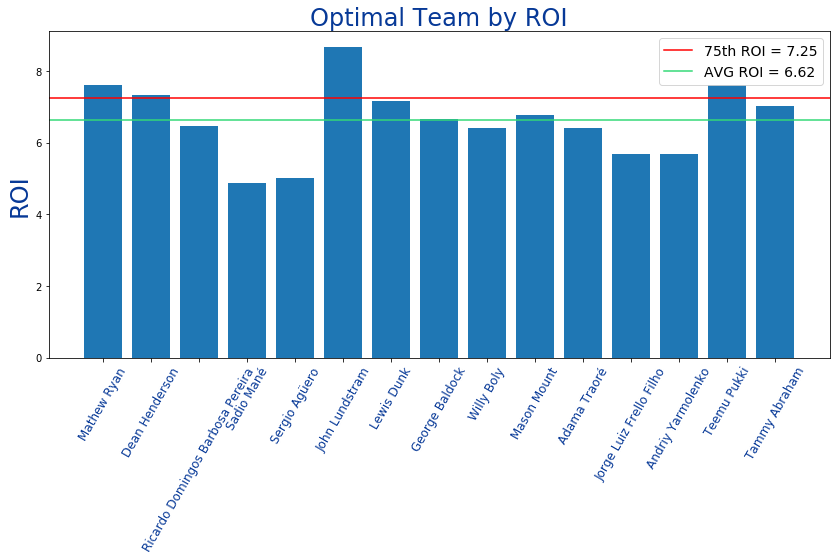

In [677]:
money_x = money_df.roi
money_y = money_df.name
ST_75th = round(money_df.describe().roi['75%'], 2)
ST_AVG = round(money_df.describe().roi['mean'], 2)

plt.bar(money_y, money_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th ROI = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ROI = ' + str(ST_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Optimal Team by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

### Top 10 ROI players by position

In [678]:
GK_df = pd.DataFrame(GK_roi)
GK_df.head(10)

bonus  cost  minutes                            name    position  \
0      6   4.6      720                     Mathew Ryan  Goalkeeper   
1      4   5.1      720   Rui Pedro dos Santos Patrício  Goalkeeper   
2      2   4.5      720                  Dean Henderson  Goalkeeper   
3      2   4.7      720                       Nick Pope  Goalkeeper   
4      1   5.0      720                 Martin Dubravka  Goalkeeper   
5      0   5.0      720               Kasper Schmeichel  Goalkeeper   
6      3   4.5      720                  Aaron Ramsdale  Goalkeeper   
7      1   5.0      720                      Bernd Leno  Goalkeeper   
8      0   4.6      681  Adrián San Miguel del Castillo  Goalkeeper   
9      0   6.1      720       Ederson Santana de Moraes  Goalkeeper   

   pts_per_90min  red_cards   roi     status  team_code      team_name  \
0           4.37          0  7.61  available         36       Brighton   
1           4.74          0  7.45  available         39         Wolves   
2           4.12          0  7.33  available         49  Sheffield Utd   
3           3.99          0  6.81  available         90        Burnley   
4           3.62          0  5.80  available          4      Newcastle   
5           3.50          0  5.60  available         13      Leicester   
6           3.12          0  5.56  available         91    Bournemouth   
7           3.37          0  5.40  available          3        Arsenal   
8           3.04          0  5.00  available         14      Liverpool   
9           3.62          0  4.75  available         43       Man City   

   total_points  transfers_in  transfers_out  
0            35        441711         340431  
1            38        504045         223477  
2            33        179262          58715  
3            32        762962         201718  
4            29         24114          32956  
5            28        235072         154828  
6            25         69659          22229  
7            27        261006         231420  
8            23        567777         212755  
9            29        652736         491051

In [679]:
DF_df = pd.DataFrame(DF_roi)
DF_df.head(10)

bonus  cost  minutes                              name  position  \
0      7   4.5      688                    John Lundstram  Defender   
1      7   4.6      720                        Lewis Dunk  Defender   
2      3   4.5      720                    George Baldock  Defender   
3      4   5.0      720                      Enda Stevens  Defender   
4      5   6.2      720  Ricardo Domingos Barbosa Pereira  Defender   
5      7   5.0      630                        Willy Boly  Defender   
6      3   4.5      387                     Jetro Willems  Defender   
7      0   4.5      720                    Matthew Lowton  Defender   
8      2   5.0      703                      Fabian Schär  Defender   
9      2   4.5      709                   Ryan Fredericks  Defender   

   pts_per_90min  red_cards   roi     status  team_code      team_name  \
0           5.09          0  8.67  available         49  Sheffield Utd   
1           4.12          0  7.17  available         36       Brighton   
2           3.74          0  6.67  available         49  Sheffield Utd   
3           4.12          0  6.60  available         49  Sheffield Utd   
4           4.99          0  6.45  available         13      Leicester   
5           4.56          1  6.40  available         39         Wolves   
6           6.49          0  6.22  available          4      Newcastle   
7           3.50          0  6.22  available         90        Burnley   
8           3.84          0  6.00  available          4      Newcastle   
9           3.42          0  6.00  available         21       West Ham   

   total_points  transfers_in  transfers_out  
0            39       1758751         219785  
1            33        526344         314697  
2            30         53208          21533  
3            33         38585          20707  
4            40        457911         179996  
5            32        249203         322008  
6            28         28362          13648  
7            28         79357          29308  
8            30        123537          88813  
9            27         70997          22524

In [680]:
MD_df = pd.DataFrame(MD_roi)
MD_df.head(10)

bonus  cost  minutes                     name    position  pts_per_90min  \
0      6   6.8      709              Mason Mount  Midfielder           5.83   
1      6   5.0      470             Adama Traoré  Midfielder           6.11   
2      5   5.1      682  Jorge Luiz Frello Filho  Midfielder           3.82   
3      5   6.0      453        Andriy Yarmolenko  Midfielder           6.74   
4      3   5.0      630            Wilfred Ndidi  Midfielder           3.99   
5      6   8.7      457             Riyad Mahrez  Midfielder           9.04   
6      3   7.6      482              David Silva  Midfielder           7.45   
7      2   4.7      691         Matteo Guendouzi  Midfielder           3.12   
8      2   6.1      575              Erik Lamela  Midfielder           4.84   
9      2   5.4      678      Georginio Wijnaldum  Midfielder           3.58   

   red_cards   roi     status  team_code  team_name  total_points  \
0          0  6.76  available          8    Chelsea            46   
1          0  6.40  available         39     Wolves            32   
2          0  5.69  available          8    Chelsea            29   
3          0  5.67  available         21   West Ham            34   
4          0  5.60  available         13  Leicester            28   
5          0  5.29  available         43   Man City            46   
6          0  5.26  available         43   Man City            40   
7          0  5.11  available          3    Arsenal            24   
8          0  5.08  available          6      Spurs            31   
9          0  5.00  available         14  Liverpool            27   

   transfers_in  transfers_out  
0       2725547         580007  
1         97668          23130  
2        303188         212375  
3        436802          51863  
4        251882         166348  
5        724013         286460  
6        734300         385568  
7        661696         322730  
8        466183         285162  
9         97941         117776

In [681]:
ST_df = pd.DataFrame(ST_roi)
ST_df.head(10)

bonus  cost  minutes                       name position  pts_per_90min  \
0      9   7.1      705                Teemu Pukki  Forward           6.88   
1     11   7.7      569              Tammy Abraham  Forward           8.53   
2      4   7.9      697              Callum Wilson  Forward           6.19   
3      5   6.3      708                Joshua King  Forward           4.82   
4      4   6.5      644              Ashley Barnes  Forward           4.74   
5      8   9.0      720                Jamie Vardy  Forward           5.74   
6      9   9.6      650            Roberto Firmino  Forward           6.64   
7      5   7.4      630           Sébastien Haller  Forward           5.28   
8      6  12.2      560              Sergio Agüero  Forward           9.79   
9     10  11.1      720  Pierre-Emerick Aubameyang  Forward           6.87   

   red_cards   roi     status  team_code    team_name  total_points  \
0          0  7.61  available         45      Norwich            54   
1          0  7.01  available          8      Chelsea            54   
2          0  6.08  available         91  Bournemouth            48   
3          0  6.03  available         91  Bournemouth            38   
4          0  5.23  available         90      Burnley            34   
5          0  5.11  available         13    Leicester            46   
6          0  5.00  available         14    Liverpool            48   
7          0  5.00  available         21     West Ham            37   
8          0  5.00  available         43     Man City            61   
9          0  4.95  available          3      Arsenal            55   

   transfers_in  transfers_out  
0       3169651         963645  
1       2911416         364121  
2        484006         784693  
3        388382        1006860  
4        988753         754564  
5        505831         509706  
6        598307         488079  
7        462580         396973  
8       1178032         504327  
9        926758         848103

## Define Clean df for graphing purposes

In [682]:
clean_df.head()

bonus  cost  minutes                           name    position  \
390      7   4.5      688                 John Lundstram    Defender   
96       6   4.6      720                    Mathew Ryan  Goalkeeper   
361      9   7.1      705                    Teemu Pukki     Forward   
538      4   5.1      720  Rui Pedro dos Santos Patrício  Goalkeeper   
403      2   4.5      720                 Dean Henderson  Goalkeeper   

     pts_per_90min  red_cards   roi     status  team_code      team_name  \
390           5.09          0  8.67  available         49  Sheffield Utd   
96            4.37          0  7.61  available         36       Brighton   
361           6.88          0  7.61  available         45        Norwich   
538           4.74          0  7.45  available         39         Wolves   
403           4.12          0  7.33  available         49  Sheffield Utd   

     total_points  transfers_in  transfers_out  
390            39       1758751         219785  
96             35        441711         340431  
361            54       3169651         963645  
538            38        504045         223477  
403            33        179262          58715

In [683]:
graph_roi = []
for row, player in clean_df.iterrows():
    playa = dict(name = player['name'], position = player.position, team=player.team_name, cost = player.cost, points = player.total_points, minutes = player.minutes, ROI = player.roi, pts_per_90min = player.pts_per_90min)
    graph_roi.append(playa)

In [684]:
graph_roi[:3]

[{'name': 'John Lundstram',
  'position': 'Defender',
  'team': 'Sheffield Utd',
  'cost': 4.5,
  'points': 39,
  'minutes': 688,
  'ROI': 8.67,
  'pts_per_90min': 5.09},
 {'name': 'Mathew Ryan',
  'position': 'Goalkeeper',
  'team': 'Brighton',
  'cost': 4.6,
  'points': 35,
  'minutes': 720,
  'ROI': 7.61,
  'pts_per_90min': 4.37},
 {'name': 'Teemu Pukki',
  'position': 'Forward',
  'team': 'Norwich',
  'cost': 7.1,
  'points': 54,
  'minutes': 705,
  'ROI': 7.61,
  'pts_per_90min': 6.88}]

### Graph by ROI

In [685]:
GK_graph = clean_df[clean_df['position'] == 'Goalkeeper']
DF_graph = clean_df[clean_df['position'] == 'Defender']
MD_graph = clean_df[clean_df['position'] == 'Midfielder']
ST_graph = clean_df[clean_df['position'] == 'Forward']

### Graph by 90_min Stat

In [686]:
sorted_players_90min = sorted(graph_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
sorted_players_90min = [player for player in sorted_players_90min if player['minutes'] >= min_min]

In [687]:
sorted_players_90min[:3]

[{'name': 'Sergio Agüero',
  'position': 'Forward',
  'team': 'Man City',
  'cost': 12.2,
  'points': 61,
  'minutes': 560,
  'ROI': 5.0,
  'pts_per_90min': 9.79},
 {'name': 'James Milner',
  'position': 'Midfielder',
  'team': 'Liverpool',
  'cost': 5.3,
  'points': 23,
  'minutes': 225,
  'ROI': 4.34,
  'pts_per_90min': 9.16},
 {'name': 'Riyad Mahrez',
  'position': 'Midfielder',
  'team': 'Man City',
  'cost': 8.7,
  'points': 46,
  'minutes': 457,
  'ROI': 5.29,
  'pts_per_90min': 9.04}]

In [688]:
df_90min = pd.DataFrame(sorted_players_90min)

In [689]:
df_90min.head()

ROI  cost  minutes                                     name  points  \
0  5.00  12.2      560                            Sergio Agüero      61   
1  4.34   5.3      225                             James Milner      23   
2  5.29   8.7      457                             Riyad Mahrez      46   
3  7.01   7.7      569                            Tammy Abraham      54   
4  4.43   7.9      371  Bernardo Mota Veiga de Carvalho e Silva      35   

     position  pts_per_90min       team  
0     Forward           9.79   Man City  
1  Midfielder           9.16  Liverpool  
2  Midfielder           9.04   Man City  
3     Forward           8.53    Chelsea  
4  Midfielder           8.47   Man City

In [690]:
GK_90min_graph = df_90min[df_90min['position'] == 'Goalkeeper']
DF_90min_graph = df_90min[df_90min['position'] == 'Defender']
MD_90min_graph = df_90min[df_90min['position'] == 'Midfielder']
ST_90min_graph = df_90min[df_90min['position'] == 'Forward']

In [691]:
GK_90min_graph.head()

ROI  cost  minutes                           name  points    position  \
51  7.45   5.1      720  Rui Pedro dos Santos Patrício      38  Goalkeeper   
62  7.61   4.6      720                    Mathew Ryan      35  Goalkeeper   
70  7.33   4.5      720                 Dean Henderson      33  Goalkeeper   
84  6.81   4.7      720                      Nick Pope      32  Goalkeeper   
85  5.71   5.6      720                   David de Gea      32  Goalkeeper   

    pts_per_90min           team  
51           4.74         Wolves  
62           4.37       Brighton  
70           4.12  Sheffield Utd  
84           3.99        Burnley  
85           3.99        Man Utd

In [692]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

## Top 10 Keepers ROI

<function matplotlib.pyplot.show(*args, **kw)>

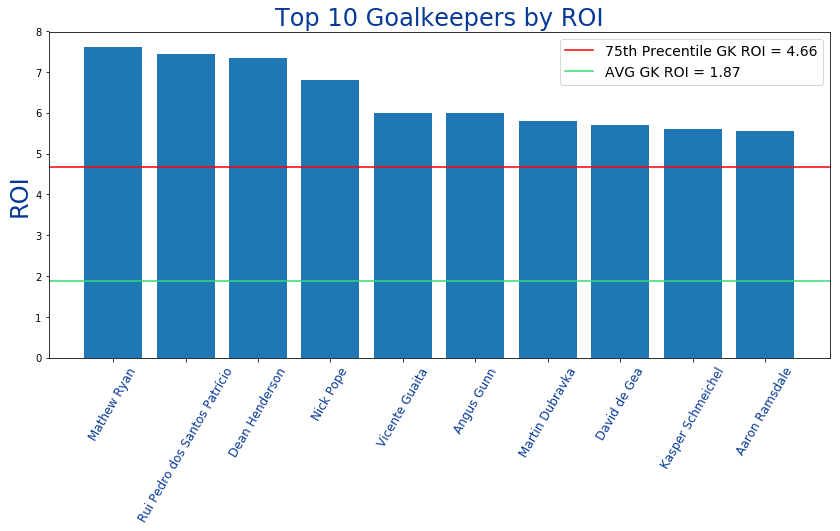

In [693]:
GK_x = GK_graph[:10].roi
GK_y = GK_graph[:10].name
GK_75th = round(GK_graph.describe().roi['75%'], 2)
GK_AVG = round(GK_graph.describe().roi['mean'], 2)

plt.bar(GK_y, GK_x)
plt.axhline(y=GK_75th, color='r', linestyle='-', label='75th Precentile GK ROI = ' + str(GK_75th))
plt.axhline(y=GK_AVG, color='#33D977', linestyle='-', label='AVG GK ROI = ' + str(GK_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Goalkeepers by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Keepers 90_min

<function matplotlib.pyplot.show(*args, **kw)>

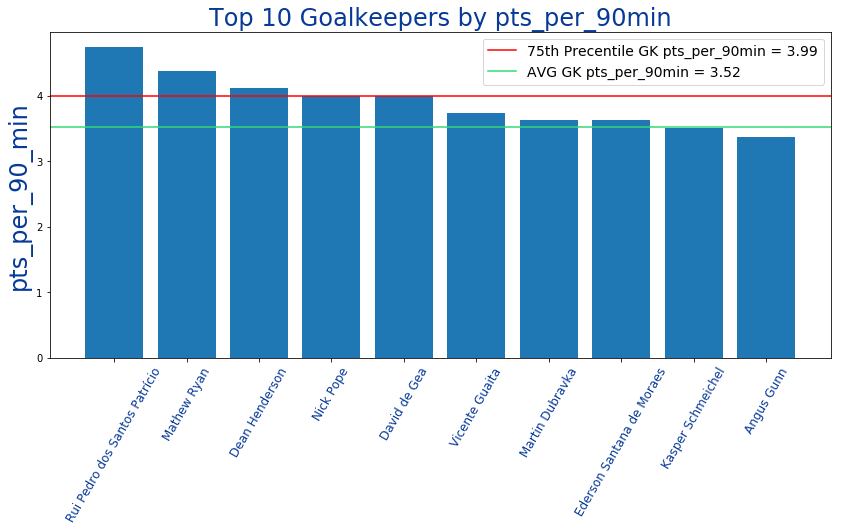

In [694]:
GK_x = GK_90min_graph[:10].pts_per_90min
GK_y = GK_90min_graph[:10].name
GK_75th = round(GK_90min_graph.describe().pts_per_90min['75%'], 2)
GK_AVG = round(GK_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(GK_y, GK_x)
plt.axhline(y=GK_75th, color='r', linestyle='-', label='75th Precentile GK pts_per_90min = ' + str(GK_75th))
plt.axhline(y=GK_AVG, color='#33D977', linestyle='-', label='AVG GK pts_per_90min = ' + str(GK_AVG))
plt.ylabel('pts_per_90_min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Goalkeepers by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Defenders

<function matplotlib.pyplot.show(*args, **kw)>

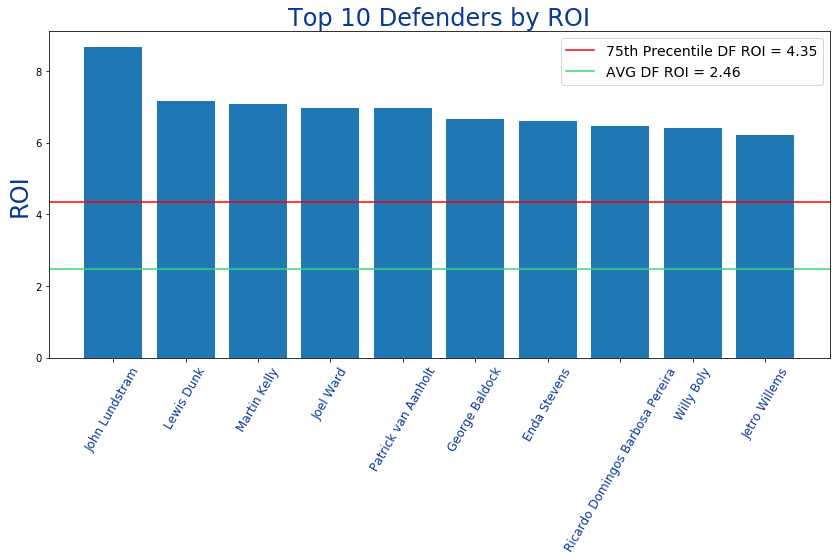

In [695]:
DF_x = DF_graph[:10].roi
DF_y = DF_graph[:10].name
DF_75th = round(DF_graph.describe().roi['75%'], 2)
DF_AVG = round(DF_graph.describe().roi['mean'], 2)

plt.bar(DF_y, DF_x)
plt.axhline(y=DF_75th, color='r', linestyle='-', label='75th Precentile DF ROI = ' + str(DF_75th))
plt.axhline(y=DF_AVG, color='#33D977', linestyle='-', label='AVG DF ROI = ' + str(DF_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Defenders by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Defenders 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

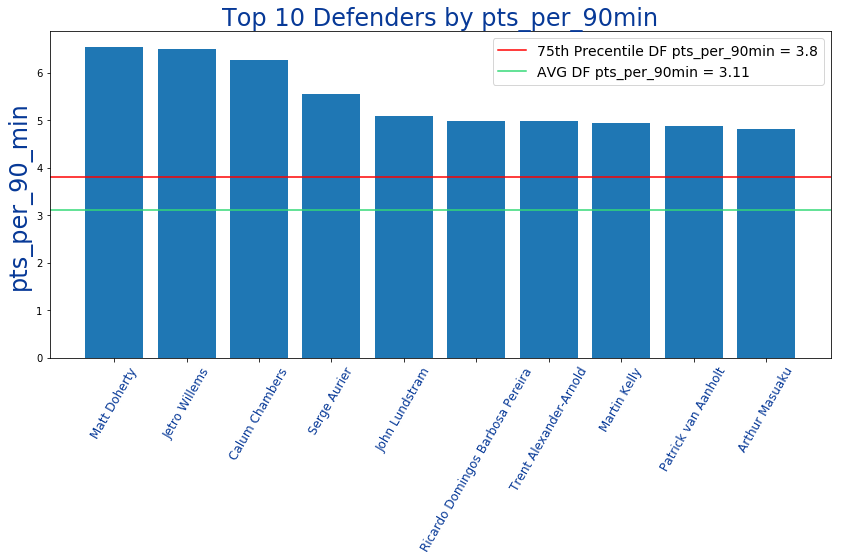

In [696]:
DF_x = DF_90min_graph[:10].pts_per_90min
DF_y = DF_90min_graph[:10].name
DF_75th = round(DF_90min_graph.describe().pts_per_90min['75%'], 2)
DF_AVG = round(DF_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(DF_y, DF_x)
plt.axhline(y=DF_75th, color='r', linestyle='-', label='75th Precentile DF pts_per_90min = ' + str(DF_75th))
plt.axhline(y=DF_AVG, color='#33D977', linestyle='-', label='AVG DF pts_per_90min = ' + str(DF_AVG))
plt.ylabel('pts_per_90_min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Defenders by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Midfielders

<function matplotlib.pyplot.show(*args, **kw)>

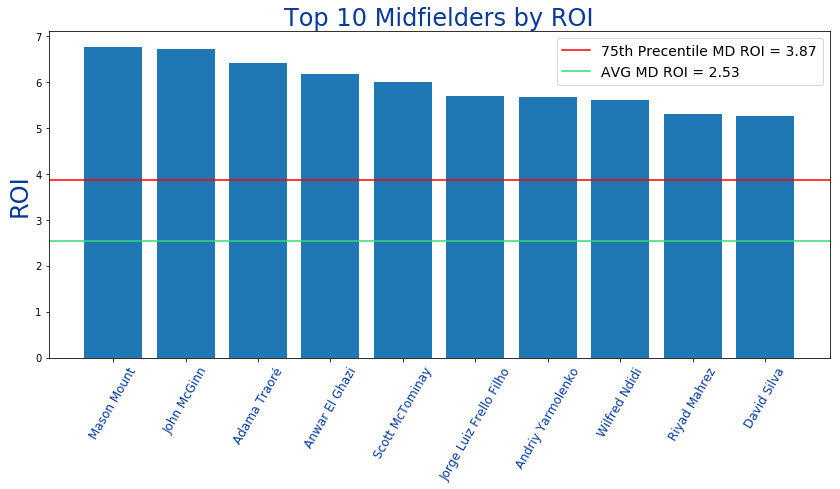

In [697]:
MD_x = MD_graph[:10].roi
MD_y = MD_graph[:10].name
MD_75th = round(MD_graph.describe().roi['75%'], 2)
MD_AVG = round(MD_graph.describe().roi['mean'], 2)

plt.bar(MD_y, MD_x)
plt.axhline(y=MD_75th, color='r', linestyle='-', label='75th Precentile MD ROI = ' + str(MD_75th))
plt.axhline(y=MD_AVG, color='#33D977', linestyle='-', label='AVG MD ROI = ' + str(MD_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Midfielders by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Midfielders 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

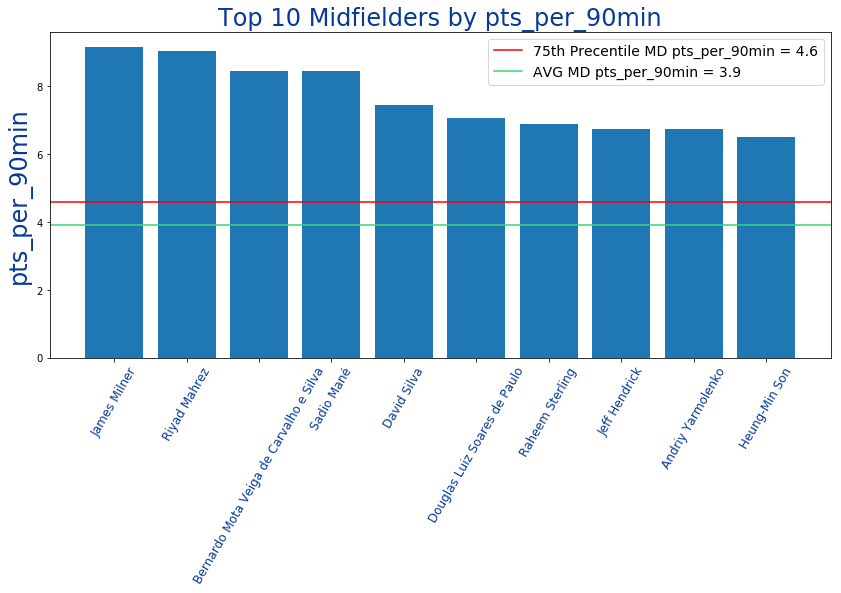

In [698]:
MD_x = MD_90min_graph[:10].pts_per_90min
MD_y = MD_90min_graph[:10].name
MD_75th = round(MD_90min_graph.describe().pts_per_90min['75%'], 2)
MD_AVG = round(MD_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(MD_y, MD_x)
plt.axhline(y=MD_75th, color='r', linestyle='-', label='75th Precentile MD pts_per_90min = ' + str(MD_75th))
plt.axhline(y=MD_AVG, color='#33D977', linestyle='-', label='AVG MD pts_per_90min = ' + str(MD_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Midfielders by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Strikers

<function matplotlib.pyplot.show(*args, **kw)>

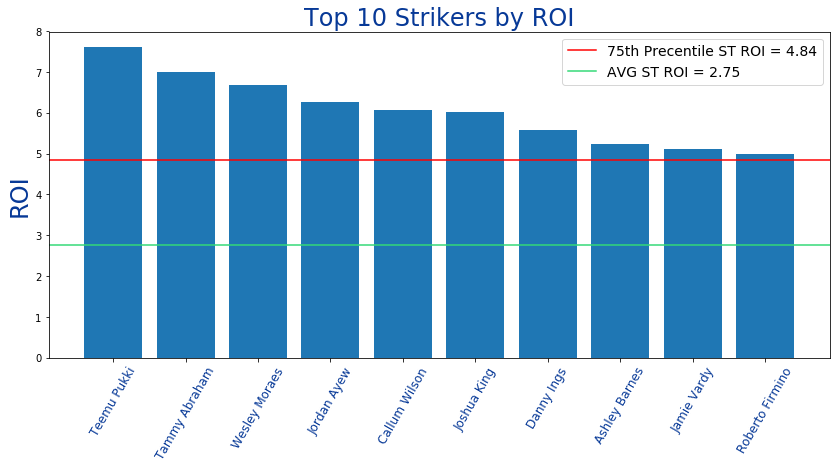

In [699]:
ST_x = ST_graph[:10].roi
ST_y = ST_graph[:10].name
ST_75th = round(ST_graph.describe().roi['75%'], 2)
ST_AVG = round(ST_graph.describe().roi['mean'], 2)

plt.bar(ST_y, ST_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile ST ROI = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ST ROI = ' + str(ST_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Strikers by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

## Top 10 Strikers 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

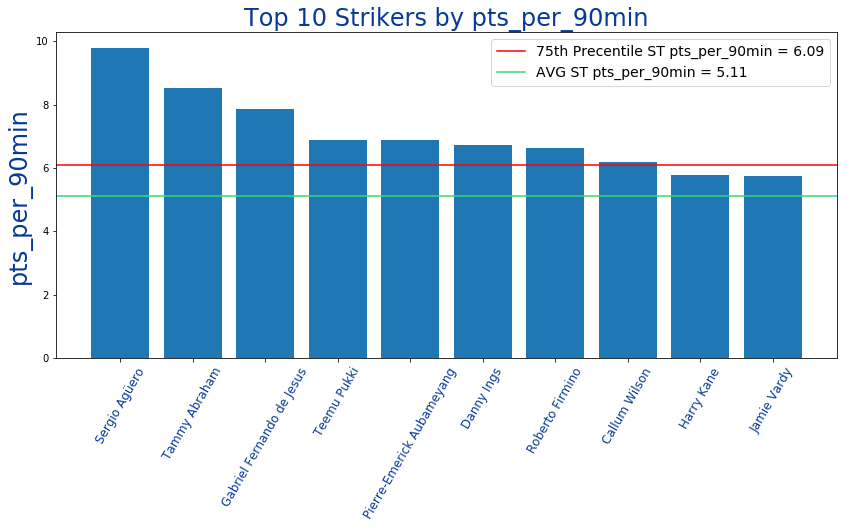

In [700]:
ST_x = ST_90min_graph[:10].pts_per_90min
ST_y = ST_90min_graph[:10].name
ST_75th = round(ST_90min_graph.describe().pts_per_90min['75%'], 2)
ST_AVG = round(ST_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(ST_y, ST_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile ST pts_per_90min = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ST pts_per_90min = ' + str(ST_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Strikers by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [701]:
team_df

code  strength Team            name Played  W  L  D  GF  GA   GD Pts
Position                                                                      
1           14         5  LIV       Liverpool      8  8  0  0  20   6  +14  24
2           43         5  MCI        Man City      8  5  2  1  27   9  +18  16
3            3         4  ARS         Arsenal      8  4  1  3  13  11   +2  15
4           13         3  LEI       Leicester      8  4  2  2  14   7   +7  14
5            8         4  CHE         Chelsea      8  4  2  2  18  14   +4  14
6           31         3  CRY  Crystal Palace      8  4  2  2   8   8    0  14
7           90         3  BUR         Burnley      8  3  2  3  11   9   +2  12
8           21         3  WHU        West Ham      8  3  2  3  11  11    0  12
9            6         4  TOT           Spurs      8  3  3  2  14  12   +2  11
10          91         3  BOU     Bournemouth      8  3  3  2  13  13    0  11
11          39         3  WOL          Wolves      8  2  2  4  11  11    0  10
12           1         4  MUN         Man Utd      8  2  3  3   9   8   +1   9
13          49         2  SHU   Sheffield Utd      8  2  3  3   7   7    0   9
14          36         2  BHA        Brighton      8  2  3  3   8  10   -2   9
15           7         2  AVL     Aston Villa      8  2  4  2  13  12   +1   8
16           4         3  NEW       Newcastle      8  2  4  2   5  13   -8   8
17          20         3  SOU     Southampton      8  2  5  1   8  15   -7   7
18          11         3  EVE         Everton      8  2  5  1   6  13   -7   7
19          45         3  NOR         Norwich      8  2  6  0  10  21  -11   6
20          57         2  WAT         Watford      8  0  5  3   4  20  -16   3

### Team Stats

In [702]:
teams_stats = team_df.iloc[:,2:12]

In [703]:
teams_stats.GF = [int(item) for item in teams_stats.GF]
teams_stats.GA = [int(item) for item in teams_stats.GA]

In [704]:
teams_stats

Team            name Played  W  L  D  GF  GA   GD Pts
Position                                                      
1         LIV       Liverpool      8  8  0  0  20   6  +14  24
2         MCI        Man City      8  5  2  1  27   9  +18  16
3         ARS         Arsenal      8  4  1  3  13  11   +2  15
4         LEI       Leicester      8  4  2  2  14   7   +7  14
5         CHE         Chelsea      8  4  2  2  18  14   +4  14
6         CRY  Crystal Palace      8  4  2  2   8   8    0  14
7         BUR         Burnley      8  3  2  3  11   9   +2  12
8         WHU        West Ham      8  3  2  3  11  11    0  12
9         TOT           Spurs      8  3  3  2  14  12   +2  11
10        BOU     Bournemouth      8  3  3  2  13  13    0  11
11        WOL          Wolves      8  2  2  4  11  11    0  10
12        MUN         Man Utd      8  2  3  3   9   8   +1   9
13        SHU   Sheffield Utd      8  2  3  3   7   7    0   9
14        BHA        Brighton      8  2  3  3   8  10   -2   9
15        AVL     Aston Villa      8  2  4  2  13  12   +1   8
16        NEW       Newcastle      8  2  4  2   5  13   -8   8
17        SOU     Southampton      8  2  5  1   8  15   -7   7
18        EVE         Everton      8  2  5  1   6  13   -7   7
19        NOR         Norwich      8  2  6  0  10  21  -11   6
20        WAT         Watford      8  0  5  3   4  20  -16   3

### Worst/ Best  Defence vs. Offence

In [705]:
worst_defence_df = teams_stats.sort_values(by = ['GA'], ascending = False)

In [706]:
worst_defence_df.head()

Team         name Played  W  L  D  GF  GA   GD Pts
Position                                                   
19        NOR      Norwich      8  2  6  0  10  21  -11   6
20        WAT      Watford      8  0  5  3   4  20  -16   3
17        SOU  Southampton      8  2  5  1   8  15   -7   7
5         CHE      Chelsea      8  4  2  2  18  14   +4  14
10        BOU  Bournemouth      8  3  3  2  13  13    0  11

In [707]:
best_defence_df = teams_stats.sort_values(by = ['GA'], ascending = True)

In [708]:
best_defence_df.head()

Team            name Played  W  L  D  GF  GA   GD Pts
Position                                                      
1         LIV       Liverpool      8  8  0  0  20   6  +14  24
4         LEI       Leicester      8  4  2  2  14   7   +7  14
13        SHU   Sheffield Utd      8  2  3  3   7   7    0   9
6         CRY  Crystal Palace      8  4  2  2   8   8    0  14
12        MUN         Man Utd      8  2  3  3   9   8   +1   9

In [709]:
GA = list(zip(worst_defence_df.name, worst_defence_df.GA))
GA_bottom5 = GA[:7]
GA_top5 = sorted(GA[-7:], key = lambda x: x[1])

In [710]:
GA_bottom5, GA_top5

([('Norwich', 21),
  ('Watford', 20),
  ('Southampton', 15),
  ('Chelsea', 14),
  ('Bournemouth', 13),
  ('Everton', 13),
  ('Newcastle', 13)],
 [('Liverpool', 6),
  ('Sheffield Utd', 7),
  ('Leicester', 7),
  ('Man Utd', 8),
  ('Crystal Palace', 8),
  ('Man City', 9),
  ('Burnley', 9)])

In [711]:
teams_stats.GA.median()

11.0

<function matplotlib.pyplot.show(*args, **kw)>

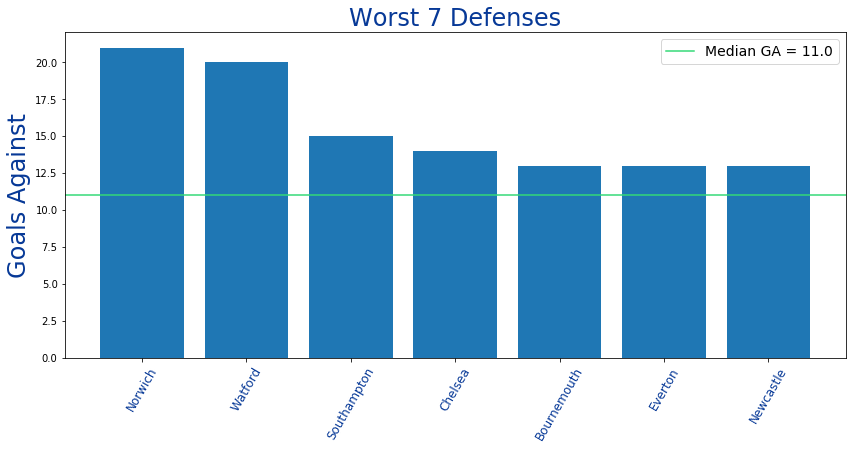

In [712]:
X = [item[0] for item in GA_bottom5]
Y = [int(item[1]) for item in GA_bottom5]

median = teams_stats.GA.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GA = ' + str(median))
plt.ylabel('Goals Against', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Worst 7 Defenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

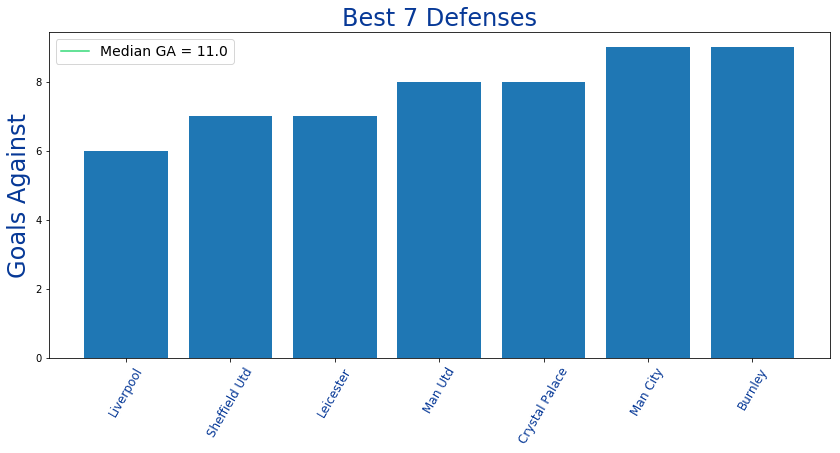

In [713]:
X = [item[0] for item in GA_top5]
Y = [int(item[1]) for item in GA_top5]

median = teams_stats.GA.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GA = ' + str(median))
plt.ylabel('Goals Against', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Best 7 Defenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.show

In [714]:
offense_df = teams_stats.sort_values(by = ['GF'], ascending = False)

In [715]:
offense_df.head()

Team       name Played  W  L  D  GF  GA   GD Pts
Position                                                 
2         MCI   Man City      8  5  2  1  27   9  +18  16
1         LIV  Liverpool      8  8  0  0  20   6  +14  24
5         CHE    Chelsea      8  4  2  2  18  14   +4  14
9         TOT      Spurs      8  3  3  2  14  12   +2  11
4         LEI  Leicester      8  4  2  2  14   7   +7  14

In [716]:
GF = list(zip(offense_df.name, offense_df.GF))
GF_top5 = GF[:7]
GF_bottom5 = GF[-7:]

In [717]:
GF_top5, GF_bottom5

([('Man City', 27),
  ('Liverpool', 20),
  ('Chelsea', 18),
  ('Spurs', 14),
  ('Leicester', 14),
  ('Arsenal', 13),
  ('Aston Villa', 13)],
 [('Brighton', 8),
  ('Crystal Palace', 8),
  ('Southampton', 8),
  ('Sheffield Utd', 7),
  ('Everton', 6),
  ('Newcastle', 5),
  ('Watford', 4)])

<function matplotlib.pyplot.show(*args, **kw)>

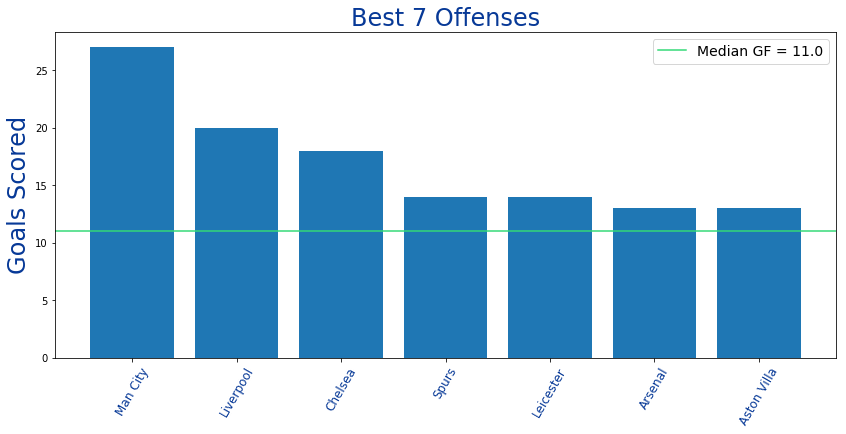

In [718]:
X = [item[0] for item in GF_top5]
Y = [int(item[1]) for item in GF_top5]

median = teams_stats.GF.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Goals Scored', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Best 7 Offenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

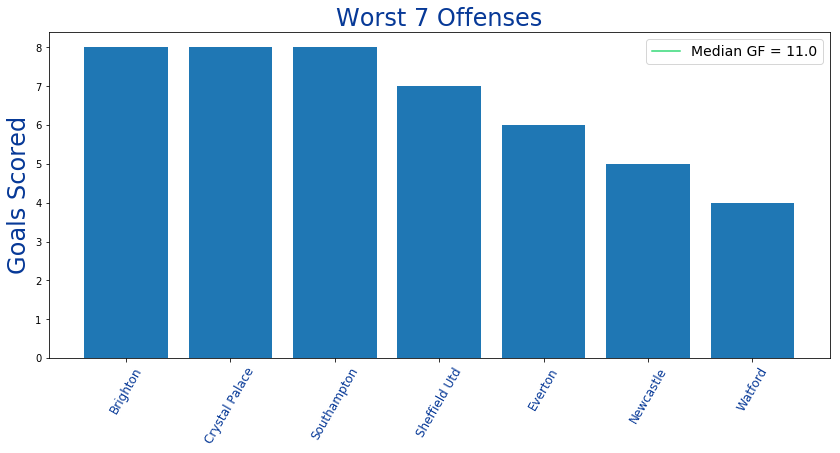

In [719]:
X = [item[0] for item in GF_bottom5]
Y = [int(item[1]) for item in GF_bottom5]

median = teams_stats.GF.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Goals Scored', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Worst 7 Offenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.show

In [720]:
stats_df = player_df[player_df.minutes >= min_min]

In [721]:
stats_df.tail()

bonus  cost  minutes                name  position  pts_per_90min  \
357      0   4.4      540  Maximillian Aarons  Defender           0.50   
480      0   6.2      180         Troy Deeney   Forward           1.99   
170      0   5.0      191       Mamadou Sakho  Defender           1.41   
377      0   4.4      181           Sam Byram  Defender           0.99   
360      0   4.0      270        Grant Hanley  Defender           0.33   

     red_cards   roi     status  team_code       team_name  total_points  \
357          0  0.68  available         45         Norwich             3   
480          0  0.65    injured         57         Watford             4   
170          0  0.60   doubtful         31  Crystal Palace             3   
377          0  0.45  available         45         Norwich             2   
360          0  0.25    injured         45         Norwich             1   

     transfers_in  transfers_out  
357         27209         120127  
480         15105         169219  
170          2680           5140  
377          3948           5707  
360        210800         158603

### Cobine Team and Player Stats

In [722]:
team_dic = {item:[] for item in team_names}

for row, player in stats_df.iterrows():
    for name in team_names:
        if player.team_name == name:
            playa = dict(name = player['name'], position = player.position, cost = player.cost, minutes = player.minutes, 
                         points = player.total_points,  roi = player.roi, pts_per_90min = player.pts_per_90min, 
                         bonus = player.bonus, red_cards = player.red_cards)
            team_dic[name].append(playa)

In [723]:
stats_df.head()

bonus  cost  minutes                           name    position  \
390      7   4.5      688                 John Lundstram    Defender   
96       6   4.6      720                    Mathew Ryan  Goalkeeper   
361      9   7.1      705                    Teemu Pukki     Forward   
538      4   5.1      720  Rui Pedro dos Santos Patrício  Goalkeeper   
403      2   4.5      720                 Dean Henderson  Goalkeeper   

     pts_per_90min  red_cards   roi     status  team_code      team_name  \
390           5.09          0  8.67  available         49  Sheffield Utd   
96            4.37          0  7.61  available         36       Brighton   
361           6.88          0  7.61  available         45        Norwich   
538           4.74          0  7.45  available         39         Wolves   
403           4.12          0  7.33  available         49  Sheffield Utd   

     total_points  transfers_in  transfers_out  
390            39       1758751         219785  
96             35        441711         340431  
361            54       3169651         963645  
538            38        504045         223477  
403            33        179262          58715

In [724]:
team_dic['Liverpool']

[{'name': 'Trent Alexander-Arnold',
  'position': 'Defender',
  'cost': 7.2,
  'minutes': 720,
  'points': 40,
  'roi': 5.56,
  'pts_per_90min': 4.99,
  'bonus': 3,
  'red_cards': 0},
 {'name': 'Joel Matip',
  'position': 'Defender',
  'cost': 5.5,
  'minutes': 540,
  'points': 30,
  'roi': 5.45,
  'pts_per_90min': 4.99,
  'bonus': 4,
  'red_cards': 0},
 {'name': 'Virgil van Dijk',
  'position': 'Defender',
  'cost': 6.5,
  'minutes': 720,
  'points': 33,
  'roi': 5.08,
  'pts_per_90min': 4.12,
  'bonus': 3,
  'red_cards': 0},
 {'name': 'Roberto Firmino',
  'position': 'Forward',
  'cost': 9.6,
  'minutes': 650,
  'points': 48,
  'roi': 5.0,
  'pts_per_90min': 6.64,
  'bonus': 9,
  'red_cards': 0},
 {'name': 'Adrián San Miguel del Castillo',
  'position': 'Goalkeeper',
  'cost': 4.6,
  'minutes': 681,
  'points': 23,
  'roi': 5.0,
  'pts_per_90min': 3.04,
  'bonus': 0,
  'red_cards': 0},
 {'name': 'Georginio Wijnaldum',
  'position': 'Midfielder',
  'cost': 5.4,
  'minutes': 678,
  'po

### Get Final Stats per Team using Pandas

In [725]:
team_stats = {item:{} for item in team_names}

for team in team_names:
    active_players = len(stats_df[stats_df.team_name == team].cost)
    tot_cost = round(stats_df[stats_df.team_name == team].cost.sum(), 3)
    tot_pts = round(stats_df[stats_df.team_name == team].total_points.sum(), 3)
    avg_player_roi = round(tot_pts / tot_cost, 3)
    avg_pts_per_player = round(tot_pts / active_players, 3)
    
    stats = dict(active_players = active_players, tot_cost = tot_cost, tot_pts = tot_pts,
               avg_pts_per_player = avg_pts_per_player,  avg_player_roi =  avg_player_roi)
    
    team_stats[team].update(stats)
    
    

In [726]:
team_stats['Newcastle']

{'active_players': 14,
 'tot_cost': 69.1,
 'tot_pts': 256,
 'avg_pts_per_player': 18.286,
 'avg_player_roi': 3.705}

In [727]:
team_stats_df = pd.DataFrame(team_stats).T

In [728]:
team_stats_df.sort_values(by = ['avg_pts_per_player'], ascending = False, inplace = True)

In [729]:
team_stats_df

active_players  avg_player_roi  avg_pts_per_player  tot_cost  \
Liverpool                 13.0           4.431              31.462      92.3   
Man City                  16.0           3.870              28.688     118.6   
Burnley                   13.0           4.668              24.846      69.2   
Leicester                 14.0           4.338              24.786      80.0   
West Ham                  13.0           4.520              24.615      70.8   
Wolves                    14.0           4.352              23.286      74.9   
Sheffield Utd             13.0           4.717              23.077      63.6   
Aston Villa               15.0           4.333              21.867      75.7   
Crystal Palace            15.0           3.934              20.667      78.8   
Arsenal                   15.0           3.566              20.400      85.8   
Spurs                     15.0           3.087              19.733      95.9   
Chelsea                   16.0           3.259              19.188      94.2   
Bournemouth               14.0           3.594              19.071      74.3   
Man Utd                   15.0           3.163              19.000      90.1   
Brighton                  15.0           3.747              18.733      75.0   
Newcastle                 14.0           3.705              18.286      69.1   
Everton                   14.0           2.993              17.786      83.2   
Southampton               15.0           3.329              16.867      76.0   
Norwich                   14.0           3.113              15.143      68.1   
Watford                   16.0           2.372              12.188      82.2   

                tot_pts  
Liverpool         409.0  
Man City          459.0  
Burnley           323.0  
Leicester         347.0  
West Ham          320.0  
Wolves            326.0  
Sheffield Utd     300.0  
Aston Villa       328.0  
Crystal Palace    310.0  
Arsenal           306.0  
Spurs             296.0  
Chelsea           307.0  
Bournemouth       267.0  
Man Utd           285.0  
Brighton          281.0  
Newcastle         256.0  
Everton           249.0  
Southampton       253.0  
Norwich           212.0  
Watford           195.0

### Build a team using 90min Stat

In [782]:
#define money team as empty list and list that tracks count of players selectd per team
money_team = []
players_selected = []
teams_selected = []

#Instantiate initial count per position
#Current players selected for each position
DF_curr = 0
MD_curr = 0 
ST_curr = 0

GK_budget = budget*GK_coef
print(GK_budget)

for item in GK_90min:
    if item['cost'] <= 5.5 and item['cost'] <= GK_budget:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        GK_budget -= item['cost']
        print('Player Selected: ' + item['name'])
        print('GK budget left: ' + str(GK_budget))
        
print(players_selected)
print(teams_selected)

9.5
Player Selected: Rui Pedro dos Santos Patrício
GK budget left: 4.4
['Rui Pedro dos Santos Patrício']
['Wolves']


### Select top 3 players by points per position

In [731]:
DF_budget = budget*DF_coef + GK_budget
MD_budget = budget*MD_coef
ST_budget = budget*ST_coef

print(DF_budget, MD_budget, ST_budget)

#Select Top Defender
money_team.append(DF_pts[0])
players_selected.append(DF_pts[0]['name'])
teams_selected.append(DF_pts[0]['team_name'])
DF_budget -= DF_pts[0]['cost']
DF_curr += 1
print('Player Selected: ' + DF_pts[0]['name'])
print('DF budget left: ' + str(DF_budget))

#Select Top Midfielder
money_team.append(MD_pts[0])
players_selected.append(MD_pts[0]['name'])
teams_selected.append(MD_pts[0]['team_name'])
MD_budget -= MD_pts[0]['cost']
MD_curr += 1
print('Player Selected: ' + MD_pts[0]['name'])
print('MD budget left: ' + str(MD_budget))


print(players_selected)
print(teams_selected)

32.9 36.0 26.0
Player Selected: Ricardo Domingos Barbosa Pereira
DF budget left: 26.7
Player Selected: Sadio Mané
MD budget left: 24.3
['Rui Pedro dos Santos Patrício', 'Ricardo Domingos Barbosa Pereira', 'Sadio Mané']
['Wolves', 'Leicester', 'Liverpool']


In [732]:
#Select Top Striker

for item in ST_pts[:3]:
    if teams_selected.count(item['team_name']) < 3 and len(money_team) == 4:
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
    break

print(len(money_team))
print(players_selected)
print(teams_selected)

3
['Rui Pedro dos Santos Patrício', 'Ricardo Domingos Barbosa Pereira', 'Sadio Mané']
['Wolves', 'Leicester', 'Liverpool']


In [733]:
print(DF_curr, MD_curr, ST_curr)

1 1 0


In [734]:
print(DF, MD, ST)

3 4 3


### Fill rest of team with 90_min_stats

In [735]:
for item in DF_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < DF_budget and DF_curr < DF:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        DF_budget -= item['cost']
        DF_curr += 1
        print('Player Selected: ' + item['name'])
        print('DF budget left: ' + str(DF_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and DF_max != DF_curr and item['cost'] <= DF_budget / (DF_max - DF_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            DF_budget -= item['cost']
            DF_curr += 1
            print('Player Selected: ' + item['name'])
            print('DF budget left: ' + str(DF_budget))
            print('# of DFs selected: ' + str(DF_curr))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Matt Doherty
DF budget left: 20.7
Player Selected: Jetro Willems
DF budget left: 16.2
Player Selected: Calum Chambers
DF budget left: 11.799999999999999
# of DFs selected: 4
Player Selected: Serge Aurier
DF budget left: 6.899999999999999
# of DFs selected: 5
7
['Rui Pedro dos Santos Patrício', 'Ricardo Domingos Barbosa Pereira', 'Sadio Mané', 'Matt Doherty', 'Jetro Willems', 'Calum Chambers', 'Serge Aurier']
['Wolves', 'Leicester', 'Liverpool', 'Wolves', 'Newcastle', 'Arsenal', 'Spurs']


In [736]:
#move leftover DF budget to MD budget
MD_budget += DF_budget

for item in MD_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < MD_budget and MD_curr < MD:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        MD_budget -= item['cost']
        MD_curr += 1
        print('Player Selected: ' + item['name'])
        print('MD budget left: ' + str(MD_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and MD_max != MD_curr and item['cost'] <= MD_budget / (MD_max - MD_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            MD_budget -= item['cost']
            MD_curr += 1
            print('Player Selected: ' + item['name'])
            print('MD budget left: ' + str(MD_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: James Milner
MD budget left: 25.9
Player Selected: Riyad Mahrez
MD budget left: 17.2
Player Selected: Bernardo Mota Veiga de Carvalho e Silva
MD budget left: 9.299999999999999
Player Selected: David Silva
MD budget left: 1.6999999999999993
11
['Rui Pedro dos Santos Patrício', 'Ricardo Domingos Barbosa Pereira', 'Sadio Mané', 'Matt Doherty', 'Jetro Willems', 'Calum Chambers', 'Serge Aurier', 'James Milner', 'Riyad Mahrez', 'Bernardo Mota Veiga de Carvalho e Silva', 'David Silva']
['Wolves', 'Leicester', 'Liverpool', 'Wolves', 'Newcastle', 'Arsenal', 'Spurs', 'Liverpool', 'Man City', 'Man City', 'Man City']


In [737]:
#move leftover MD budget to ST budget
ST_budget += MD_budget

for item in ST_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < ST_budget and ST_curr < ST:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        ST_budget -= item['cost']
        ST_curr += 1
        print('Player Selected: ' + item['name'])
        print('ST budget left: ' + str(ST_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and ST_max != ST_curr and item['cost'] <= ST_budget / (ST_max - ST_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Tammy Abraham
ST budget left: 20.0
Player Selected: Teemu Pukki
ST budget left: 12.9
Player Selected: Pierre-Emerick Aubameyang
ST budget left: 1.8000000000000007
14
['Rui Pedro dos Santos Patrício', 'Ricardo Domingos Barbosa Pereira', 'Sadio Mané', 'Matt Doherty', 'Jetro Willems', 'Calum Chambers', 'Serge Aurier', 'James Milner', 'Riyad Mahrez', 'Bernardo Mota Veiga de Carvalho e Silva', 'David Silva', 'Tammy Abraham', 'Teemu Pukki', 'Pierre-Emerick Aubameyang']
['Wolves', 'Leicester', 'Liverpool', 'Wolves', 'Newcastle', 'Arsenal', 'Spurs', 'Liverpool', 'Man City', 'Man City', 'Man City', 'Chelsea', 'Norwich', 'Arsenal']


In [738]:
money_df = pd.DataFrame(money_team)

In [739]:
money_df

bonus  cost  minutes                                     name    position  \
0       4   5.1      720            Rui Pedro dos Santos Patrício  Goalkeeper   
1       5   6.2      720         Ricardo Domingos Barbosa Pereira    Defender   
2       8  11.7      606                               Sadio Mané  Midfielder   
3       3   6.0      412                             Matt Doherty    Defender   
4       3   4.5      387                            Jetro Willems    Defender   
5       2   4.4      315                           Calum Chambers    Defender   
6       2   4.9      210                             Serge Aurier    Defender   
7       3   5.3      225                             James Milner  Midfielder   
8       6   8.7      457                             Riyad Mahrez  Midfielder   
9       2   7.9      371  Bernardo Mota Veiga de Carvalho e Silva  Midfielder   
10      3   7.6      482                              David Silva  Midfielder   
11     11   7.7      569                            Tammy Abraham     Forward   
12      9   7.1      705                              Teemu Pukki     Forward   
13     10  11.1      720                Pierre-Emerick Aubameyang     Forward   

    pts_per_90min  red_cards   roi     status  team_code  team_name  \
0            4.74          0  7.45  available         39     Wolves   
1            4.99          0  6.45  available         13  Leicester   
2            8.45          0  4.87  available         14  Liverpool   
3            6.54          0  5.00  available         39     Wolves   
4            6.49          0  6.22  available          4  Newcastle   
5            6.27          0  5.00  available          3    Arsenal   
6            5.55          1  2.65  available          6      Spurs   
7            9.16          0  4.34  available         14  Liverpool   
8            9.04          0  5.29  available         43   Man City   
9            8.47          0  4.43  available         43   Man City   
10           7.45          0  5.26  available         43   Man City   
11           8.53          0  7.01  available          8    Chelsea   
12           6.88          0  7.61  available         45    Norwich   
13           6.87          0  4.95  available          3    Arsenal   

    total_points  transfers_in  transfers_out  
0             38        504045         223477  
1             40        457911         179996  
2             57       1332868         633541  
3             30         80361         140015  
4             28         28362          13648  
5             22         68227          52379  
6             13        256452         162716  
7             23         23185          44074  
8             46        724013         286460  
9             35        539507        1188010  
10            40        734300         385568  
11            54       2911416         364121  
12            54       3169651         963645  
13            55        926758         848103

<function matplotlib.pyplot.show(*args, **kw)>

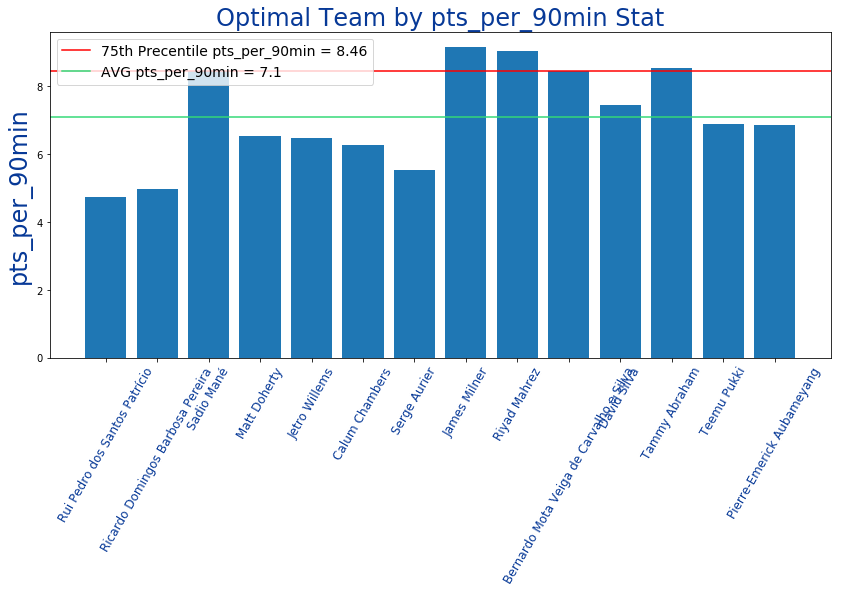

In [740]:
money_x = money_df.pts_per_90min
money_y = money_df.name
ST_75th = round(money_df.describe().pts_per_90min['75%'], 2)
ST_AVG = round(money_df.describe().pts_per_90min['mean'], 2)

plt.bar(money_y, money_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile pts_per_90min = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG pts_per_90min = ' + str(ST_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Optimal Team by pts_per_90min Stat', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [741]:
top100_users = pd.read_csv('fEPL_user_data_test.csv', index_col='users')

In [742]:
top100_users.head()

rank  user_id_num  total_points  game_week_points  \
users                                                                      
nick tanner               1       568651           587                65   
Boyko Iliev               2       191908           578                57   
Kittipong Kaewsopon       3       406431           573                59   
Raushan Uttamchandani     4      1229681           569                54   
david croley              4      1966144           569                43   

                                                      formation  \
users                                                             
nick tanner            {'GKP': 1, 'DEF': 3, 'MID': 5, 'FWD': 2}   
Boyko Iliev            {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   
Kittipong Kaewsopon    {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   
Raushan Uttamchandani  {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   
david croley           {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   

                                  GKP_1               GKP_2  \
users                                                         
nick tanner              Ryan-BHA-start    McGovern-NOR-sub   
Boyko Iliev              Pope-BUR-start    Patrício-WOL-sub   
Kittipong Kaewsopon      Ryan-BHA-start  Schmeichel-LEI-sub   
Raushan Uttamchandani    Ryan-BHA-start    McGovern-NOR-sub   
david croley           Heaton-AVL-start        Ryan-BHA-sub   

                                            DEF_1                DEF_2  \
users                                                                    
nick tanner                       Kelly-CRY-start       Dunk-BHA-start   
Boyko Iliev            Alexander-Arnold-LIV-start  O'Connell-SHU-start   
Kittipong Kaewsopon            van Dijk-LIV-start    Coleman-EVE-start   
Raushan Uttamchandani            Tomori-CHE-start    Pieters-BUR-start   
david croley                      Mings-AVL-start   Otamendi-MCI-start   

                                     DEF_3  ...            DEF_5  \
users                                       ...                    
nick tanner            Lundstram-SHU-start  ...     Rico-BOU-sub   
Boyko Iliev                  Mee-BUR-start  ...     Boly-WOL-sub   
Kittipong Kaewsopon        Kelly-CRY-start  ...  Söyüncü-LEI-sub   
Raushan Uttamchandani   Otamendi-MCI-start  ...    Kelly-CRY-sub   
david croley           Robertson-LIV-start  ...     Dunk-BHA-sub   

                                    MID_1                 MID_2  \
users                                                             
nick tanner            Sterling-MCI-start        Mané-LIV-start   
Boyko Iliev               Mount-CHE-start  Yarmolenko-WHU-start   
Kittipong Kaewsopon       Mount-CHE-start        Pépé-ARS-start   
Raushan Uttamchandani  Sterling-MCI-start    Cantwell-NOR-start   
david croley              Mount-CHE-start        Mané-LIV-start   

                                    MID_3                  MID_4  \
users                                                              
nick tanner               Mount-CHE-start        Salah-LIV-start   
Boyko Iliev                Mané-LIV-start     Cantwell-NOR-start   
Kittipong Kaewsopon        Mané-LIV-start  David Silva-MCI-start   
Raushan Uttamchandani      Mané-LIV-start          Son-TOT-start   
david croley           Cantwell-NOR-start       McGinn-AVL-start   

                                      MID_5              FWD_1  \
users                                                            
nick tanner              Cantwell-NOR-start  Abraham-CHE-start   
Boyko Iliev               De Bruyne-MCI-sub    Pukki-NOR-start   
Kittipong Kaewsopon    Harry Wilson-BOU-sub    Pukki-NOR-start   
Raushan Uttamchandani     De Bruyne-MCI-sub  Abraham-CHE-start   
david croley              De Bruyne-MCI-sub    Pukki-NOR-start   

                                   FWD_2                    FWD_3  \
users                                                               
nick tanner              Pukki-NOR

### Function to extract names from player string

In [743]:
def partition_names(names_list):
    clean_list = [item.partition("-")[0] for item in names_list]
    return clean_list

### Function to get the list of all selected players by position

In [744]:
def get_top100_teams(team_df):
    #create lists by position
    #GK_list
    GK_list = list(team_df.GKP_1)
    GK_list.extend(list(team_df.GKP_2))
    GK_final = partition_names(GK_list)
    
    #DF_list
    DF_list = list(team_df.DEF_1)
    DF_list.extend(list(team_df.DEF_2))
    DF_list.extend(list(team_df.DEF_3))
    DF_list.extend(list(team_df.DEF_4))
    DF_list.extend(list(team_df.DEF_5))
    DF_final = partition_names(DF_list)
    
    #MD_list
    MD_list = list(team_df.MID_1)
    MD_list.extend(list(team_df.MID_2))
    MD_list.extend(list(team_df.MID_3))
    MD_list.extend(list(team_df.MID_4))
    MD_list.extend(list(team_df.MID_5))
    MD_final = partition_names(MD_list)
    
    #ST_list
    ST_list = list(team_df.FWD_1)
    ST_list.extend(list(team_df.FWD_2))
    ST_list.extend(list(team_df.FWD_3))
    ST_final = partition_names(ST_list)
    
    return GK_final, DF_final, MD_final, ST_final

In [745]:
#get the final clean list of players per position
GK_final, DF_final, MD_final, ST_final = get_top100_teams(top100_users)[0], get_top100_teams(top100_users)[1], get_top100_teams(top100_users)[2], get_top100_teams(top100_users)[3]

In [746]:
GK_final[:3]

['Ryan', 'Pope', 'Ryan']

In [747]:
MD_final[:3]

['Sterling', 'Mount', 'Mount']

In [748]:
DF_final[:3]

['Kelly', 'Alexander', 'van Dijk']

In [749]:
ST_final[:3]

['Abraham', 'Pukki', 'Pukki']

### Function to get you top_n players by position ordered by # of times they were picked

In [750]:
def return_top_n(players, top_n = 10):
    ranked = Counter(players).most_common(top_n)
    return ranked

In [751]:
GK_top10 = return_top_n(GK_final)

In [752]:
GK_top10

[('Button', 38),
 ('Pope', 37),
 ('Ryan', 23),
 ('Heaton', 19),
 ('Adrián', 14),
 ('McGovern', 11),
 ('Patrício', 10),
 ('de Gea', 8),
 ('Stekelenburg', 7),
 ('Ederson', 5)]

In [753]:
DF_top10 = return_top_n(DF_final)

In [754]:
DF_top10

[('Lundstram', 76),
 ('Kelly', 61),
 ('Alexander', 42),
 ('Dunk', 30),
 ('Otamendi', 24),
 ('Rico', 23),
 ('Söyüncü', 19),
 ('van Dijk', 17),
 ('Tomori', 17),
 ('Robertson', 16)]

In [755]:
MD_top10 = return_top_n(MD_final)

In [756]:
MD_top10

[('Mané', 64),
 ('Mount', 62),
 ('De Bruyne', 58),
 ('Sterling', 46),
 ('Cantwell', 42),
 ('Salah', 38),
 ('Son', 26),
 ('McGinn', 23),
 ('Mahrez', 15),
 ('Dendoncker', 14)]

In [757]:
ST_top10 = return_top_n(ST_final)

In [758]:
ST_top10

[('Abraham', 69),
 ('Pukki', 62),
 ('Agüero', 35),
 ('Vardy', 18),
 ('Greenwood', 18),
 ('Aubameyang', 16),
 ('Callum Wilson', 14),
 ('Firmino', 14),
 ('Kane', 11),
 ('Wesley', 9)]

<function matplotlib.pyplot.show(*args, **kw)>

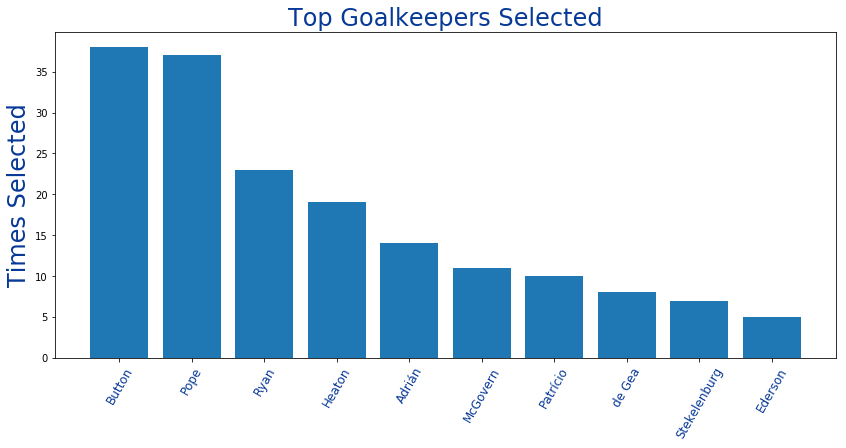

In [759]:
X = [item[0] for item in GK_top10]
Y = [item[1] for item in GK_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Goalkeepers Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

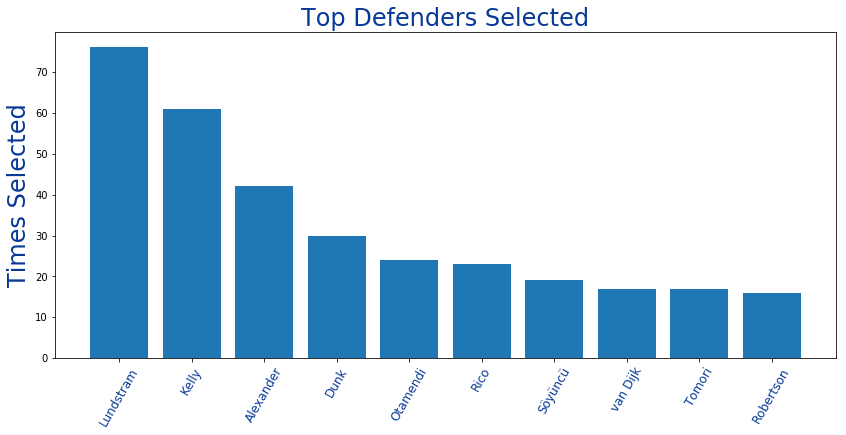

In [760]:
X = [item[0] for item in DF_top10]
Y = [item[1] for item in DF_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Defenders Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

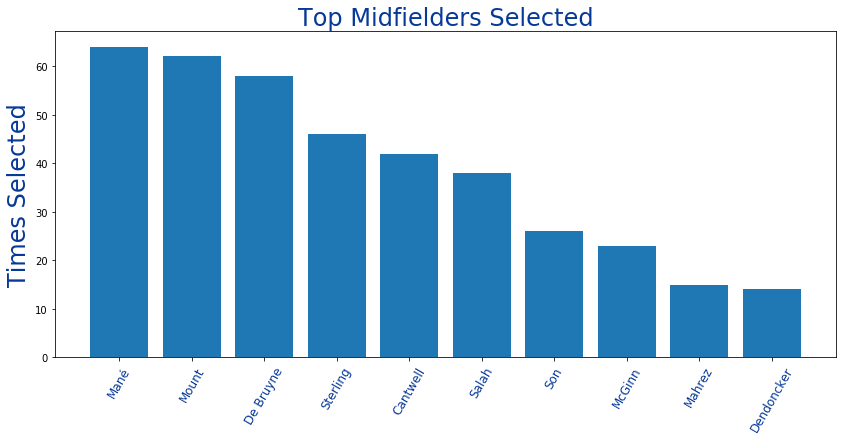

In [761]:
X = [item[0] for item in MD_top10]
Y = [item[1] for item in MD_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Midfielders Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

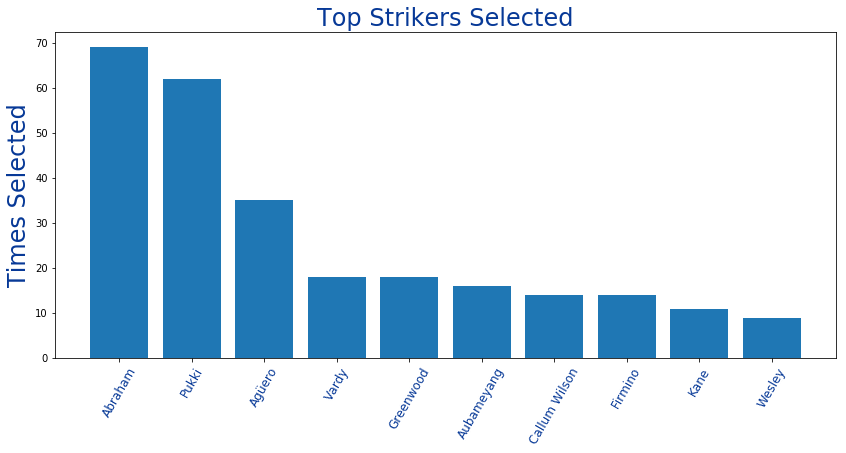

In [762]:
X = [item[0] for item in ST_top10]
Y = [item[1] for item in ST_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Strikers Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show

In [763]:
top_managers_team = GK_top10[:2]+ DF_top10[:5] + MD_top10[:5] + ST_top10[:3]

In [764]:
top_managers_team

[('Button', 38),
 ('Pope', 37),
 ('Lundstram', 76),
 ('Kelly', 61),
 ('Alexander', 42),
 ('Dunk', 30),
 ('Otamendi', 24),
 ('Mané', 64),
 ('Mount', 62),
 ('De Bruyne', 58),
 ('Sterling', 46),
 ('Cantwell', 42),
 ('Abraham', 69),
 ('Pukki', 62),
 ('Agüero', 35)]

<function matplotlib.pyplot.show(*args, **kw)>

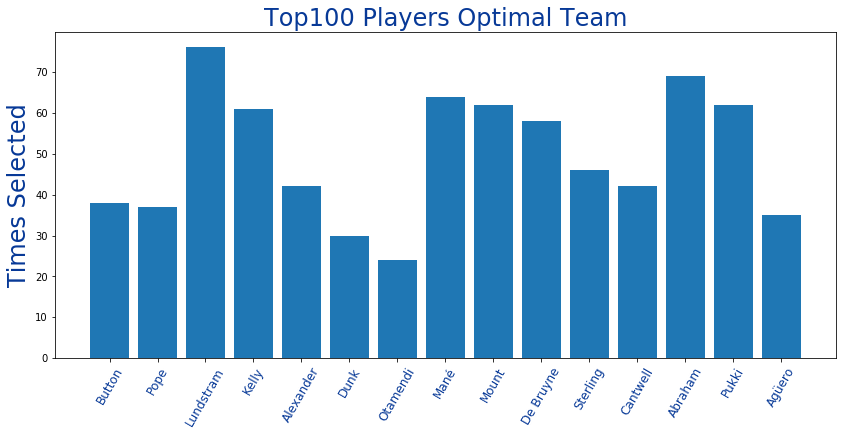

In [779]:
X = [item[0] for item in top_managers_team]
Y = [item[1] for item in top_managers_team]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top100 Players Optimal Team', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show

### Latest Injury Updates from independant site that updates faster than the Fantasy site

In [766]:
injuries = 'http://www.premierinjuries.com/?fbclid=IwAR1Uz0TTwRMOvsq1jlefIztPPg7qtPdnag3zrHxh_39wV4CZoMG0ZWq6MYU'
injuries_tab = pd.read_html(injuries)[0]

In [767]:
injuries_tab

Player                   Reason
0         Robert Snodgrass    Calf/Shin/Heel Injury
1  Johann Berg Gudmundsson                    Other
2            Mateo Kovacic                    Other
3      Andreas Christensen  Groin/Hip/Pelvic Injury
4             N'Golo Kante  Groin/Hip/Pelvic Injury
5              Reece James        Ankle/Foot Injury
6            Todd Cantwell             Thigh Injury
7            Dani Ceballos             Thigh Injury
8             Kenny McLean  Groin/Hip/Pelvic Injury
9            Thomas Heaton                    Other

In [768]:
top100_users.head()

rank  user_id_num  total_points  game_week_points  \
users                                                                      
nick tanner               1       568651           587                65   
Boyko Iliev               2       191908           578                57   
Kittipong Kaewsopon       3       406431           573                59   
Raushan Uttamchandani     4      1229681           569                54   
david croley              4      1966144           569                43   

                                                      formation  \
users                                                             
nick tanner            {'GKP': 1, 'DEF': 3, 'MID': 5, 'FWD': 2}   
Boyko Iliev            {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   
Kittipong Kaewsopon    {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   
Raushan Uttamchandani  {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   
david croley           {'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}   

                                  GKP_1               GKP_2  \
users                                                         
nick tanner              Ryan-BHA-start    McGovern-NOR-sub   
Boyko Iliev              Pope-BUR-start    Patrício-WOL-sub   
Kittipong Kaewsopon      Ryan-BHA-start  Schmeichel-LEI-sub   
Raushan Uttamchandani    Ryan-BHA-start    McGovern-NOR-sub   
david croley           Heaton-AVL-start        Ryan-BHA-sub   

                                            DEF_1                DEF_2  \
users                                                                    
nick tanner                       Kelly-CRY-start       Dunk-BHA-start   
Boyko Iliev            Alexander-Arnold-LIV-start  O'Connell-SHU-start   
Kittipong Kaewsopon            van Dijk-LIV-start    Coleman-EVE-start   
Raushan Uttamchandani            Tomori-CHE-start    Pieters-BUR-start   
david croley                      Mings-AVL-start   Otamendi-MCI-start   

                                     DEF_3  ...            DEF_5  \
users                                       ...                    
nick tanner            Lundstram-SHU-start  ...     Rico-BOU-sub   
Boyko Iliev                  Mee-BUR-start  ...     Boly-WOL-sub   
Kittipong Kaewsopon        Kelly-CRY-start  ...  Söyüncü-LEI-sub   
Raushan Uttamchandani   Otamendi-MCI-start  ...    Kelly-CRY-sub   
david croley           Robertson-LIV-start  ...     Dunk-BHA-sub   

                                    MID_1                 MID_2  \
users                                                             
nick tanner            Sterling-MCI-start        Mané-LIV-start   
Boyko Iliev               Mount-CHE-start  Yarmolenko-WHU-start   
Kittipong Kaewsopon       Mount-CHE-start        Pépé-ARS-start   
Raushan Uttamchandani  Sterling-MCI-start    Cantwell-NOR-start   
david croley              Mount-CHE-start        Mané-LIV-start   

                                    MID_3                  MID_4  \
users                                                              
nick tanner               Mount-CHE-start        Salah-LIV-start   
Boyko Iliev                Mané-LIV-start     Cantwell-NOR-start   
Kittipong Kaewsopon        Mané-LIV-start  David Silva-MCI-start   
Raushan Uttamchandani      Mané-LIV-start          Son-TOT-start   
david croley           Cantwell-NOR-start       McGinn-AVL-start   

                                      MID_5              FWD_1  \
users                                                            
nick tanner              Cantwell-NOR-start  Abraham-CHE-start   
Boyko Iliev               De Bruyne-MCI-sub    Pukki-NOR-start   
Kittipong Kaewsopon    Harry Wilson-BOU-sub    Pukki-NOR-start   
Raushan Uttamchandani     De Bruyne-MCI-sub  Abraham-CHE-start   
david croley              De Bruyne-MCI-sub    Pukki-NOR-start   

                                   FWD_2                    FWD_3  \
users                                                               
nick tanner              Pukki-NOR

In [769]:
test = top100_users.formation

### Extract formations as a list in a readable format

In [770]:
formations = [item.split(",")[1][8] + "-" + item.split(",")[2][8] + "-" + item.split(",")[3][8] for item in test]

In [771]:
formations[:5]

['3-5-2', '3-4-3', '3-4-3', '3-4-3', '3-4-3']

### Use top_n function to get a tuple of ranked formations by count

In [772]:
top_form = return_top_n(formations, 6)

In [773]:
top_form

[('3-4-3', 52),
 ('4-3-3', 18),
 ('4-4-2', 14),
 ('3-5-2', 12),
 ('5-2-3', 2),
 ('5-3-2', 2)]

<function matplotlib.pyplot.show(*args, **kw)>

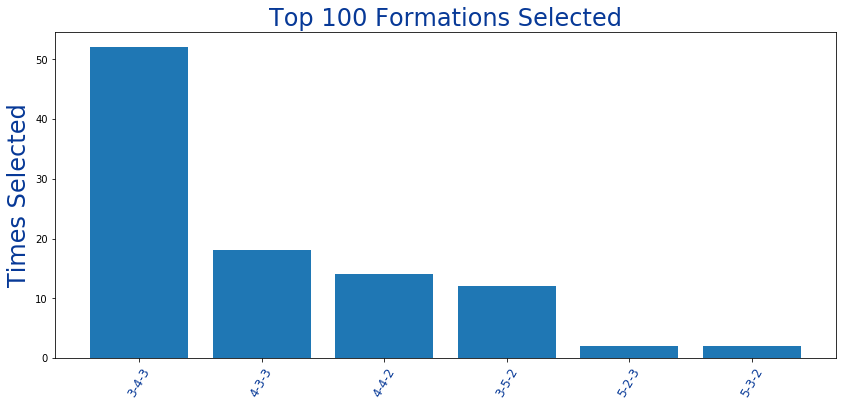

In [774]:
X = [item[0] for item in top_form]
Y = [item[1] for item in top_form]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 100 Formations Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.show